In [44]:
import pandas as pd
import numpy as np
# Load the CSV file
df = pd.read_csv('clean2.csv')
df.shape

(6054, 101)

In [45]:
# Fix non-numeric columns in the dataset by converting boolean columns to integers

# First, check which columns are boolean type
bool_columns = df.select_dtypes(include=['bool']).columns.tolist()

if bool_columns:
    print(f"Converting {len(bool_columns)} boolean columns to integers:")
    print(bool_columns)
    
    # Convert boolean columns to integers (0/1)
    for col in bool_columns:
        df[col] = df[col].astype(int)
    
    print("Conversion complete. All boolean columns are now integers.")
else:
    # If there are no boolean columns, check which district columns need fixing
    district_columns = [col for col in df.columns if col.startswith('district_') and col != 'district_standardized']
    
    print(f"Ensuring {len(district_columns)} district columns are integers:")
    # Convert district columns to integers explicitly
    for col in district_columns:
        if df[col].dtype != 'int64':
            original_dtype = df[col].dtype
            df[col] = df[col].astype(int)
            print(f"Converted {col} from {original_dtype} to int")
        else:
            print(f"{col} is already int64 type")

# Verify the conversion
print("\nUpdated data types:")
for col in [c for c in df.columns if c.startswith('district_') and c != 'district_standardized']:
    print(f"{col}: {df[col].dtype}")

# Now you can proceed with your regression analysis using the fixed dataset

Ensuring 17 district columns are integers:
district_Bemowo is already int64 type
district_Białołęka is already int64 type
district_Bielany is already int64 type
district_Mokotów is already int64 type
district_Ochota is already int64 type
district_Other is already int64 type
district_Praga-Południe is already int64 type
district_Praga-Północ is already int64 type
district_Targówek is already int64 type
district_Ursus is already int64 type
district_Ursynów is already int64 type
district_Wilanów is already int64 type
district_Wola is already int64 type
district_Włochy is already int64 type
district_Śródmieście is already int64 type
district_Żoliborz is already int64 type
district_other is already int64 type

Updated data types:
district_Bemowo: int64
district_Białołęka: int64
district_Bielany: int64
district_Mokotów: int64
district_Ochota: int64
district_Other: int64
district_Praga-Południe: int64
district_Praga-Północ: int64
district_Targówek: int64
district_Ursus: int64
district_Ursynów

In [46]:
# Define the columns to drop - all ratio variables and total_amenities_score
columns_to_drop = [
    # Ratio variables
    'kitchen_furniture_ratio',
    'security_ratio',
    'tech_ratio',
    'premium_ratio',
    'infrastructure_ratio',
    'interior_ratio',
    'total_amenities_ratio',
    'total_amenities_score',
    'has_premium_amenities',
    'weighted_amenities_score',
    'kitchen_appliances_score',
    'price_per_sqm',
    'price_per_room',

     # Size categorical features (derived from area)
    'size_Very_Small', 'size_Small', 'size_Medium', 'size_Large', 'size_Very_Large', 'size_Huge', 'size_category',
    
    # Floor categorical features (if keeping numeric)
    'floor_Ground', 'floor_High', 'floor_Low', 'floor_Mid', 'floor_Special', 'floor_VeryHigh', 'floor_category',
    
    # Building height categories (keeping building_floors_num)
    'height_high_rise', 'height_low_rise', 'height_mid_rise', 'height_skyscraper',
    

    
    # Age categories (if keeping build_year)
    'age_pre_1949', 'age_1950_1979', 'age_1980_1999', 'age_2000_2009', 'age_2010_2019', 'age_2020_plus', 'age_unknown', 'build_age_group',

        # Binary indicator derived from rooms_num
    'many_rooms',
    
    # Only need n-1 window type indicators
    'window_Other',
    
    # Only need n-1 building type indicators
    'building_type_Other',

    'building_type_block',
    'rooms_per_area'

]

# Drop the columns
df = df.drop(columns=columns_to_drop)

# Verify the columns were dropped
print(f"DataFrame shape: {df.shape}")
print(f"Number of columns dropped: {len(columns_to_drop)}")

DataFrame shape: (6054, 57)
Number of columns dropped: 44


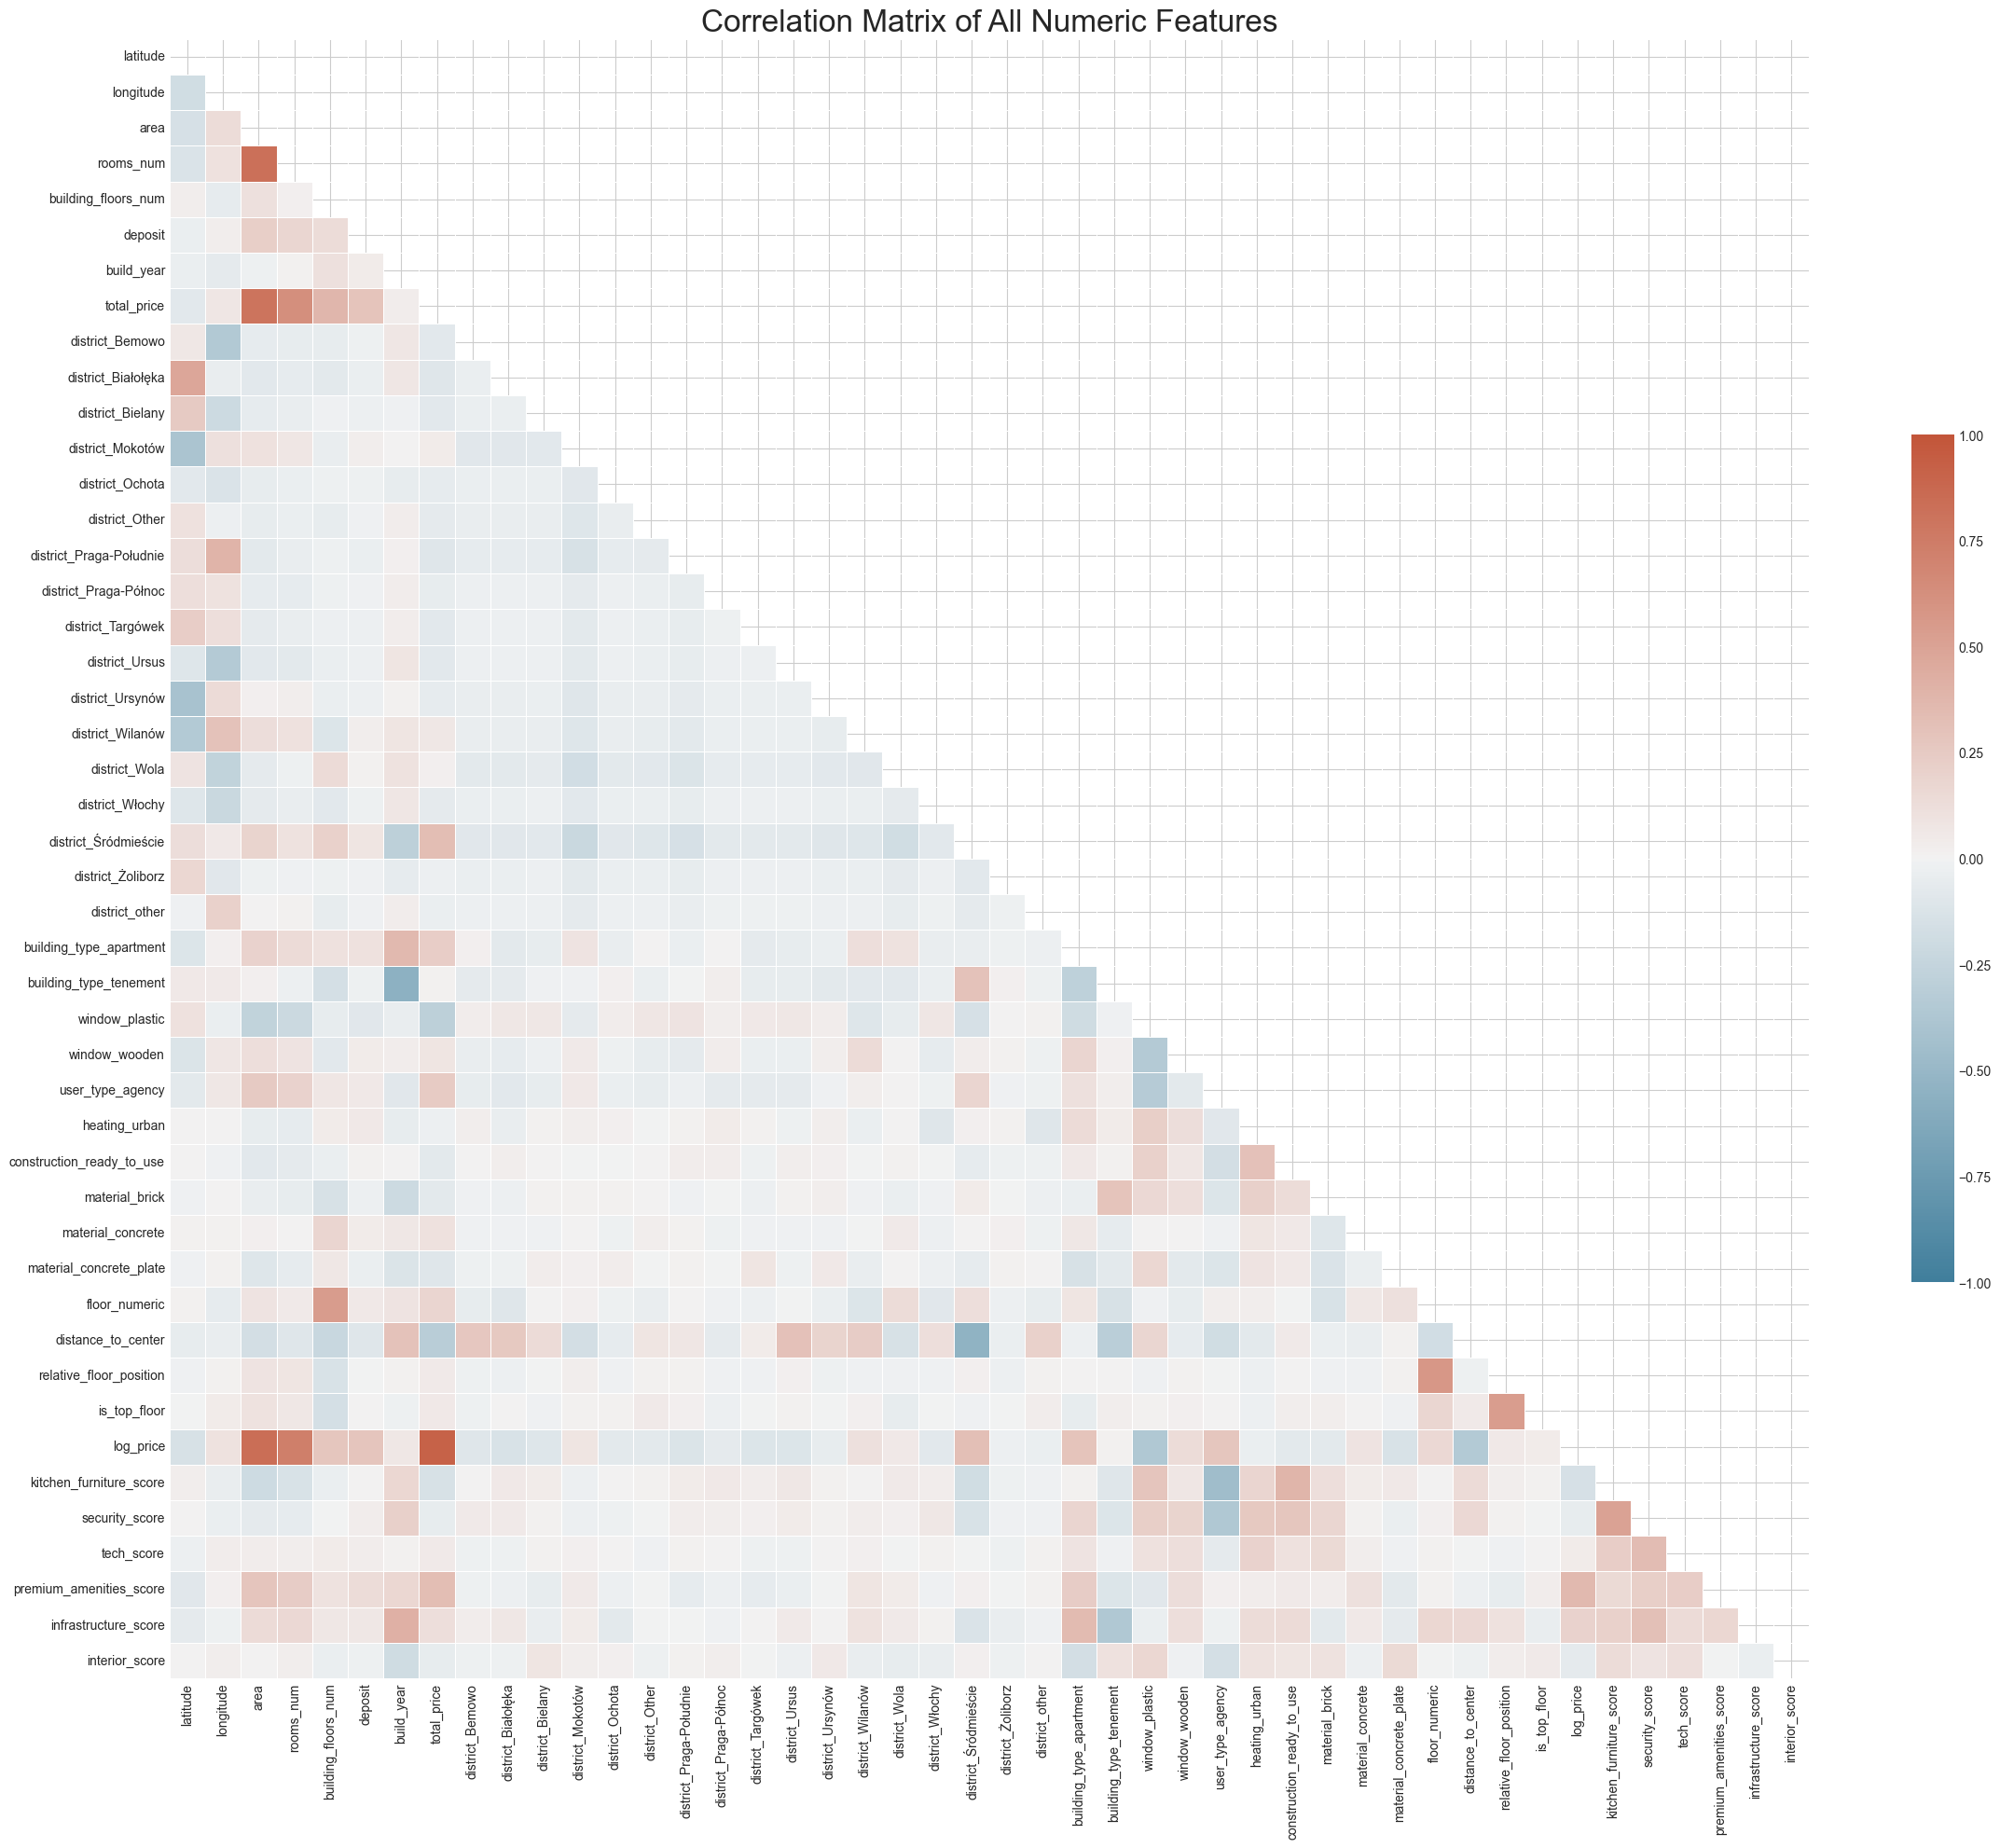

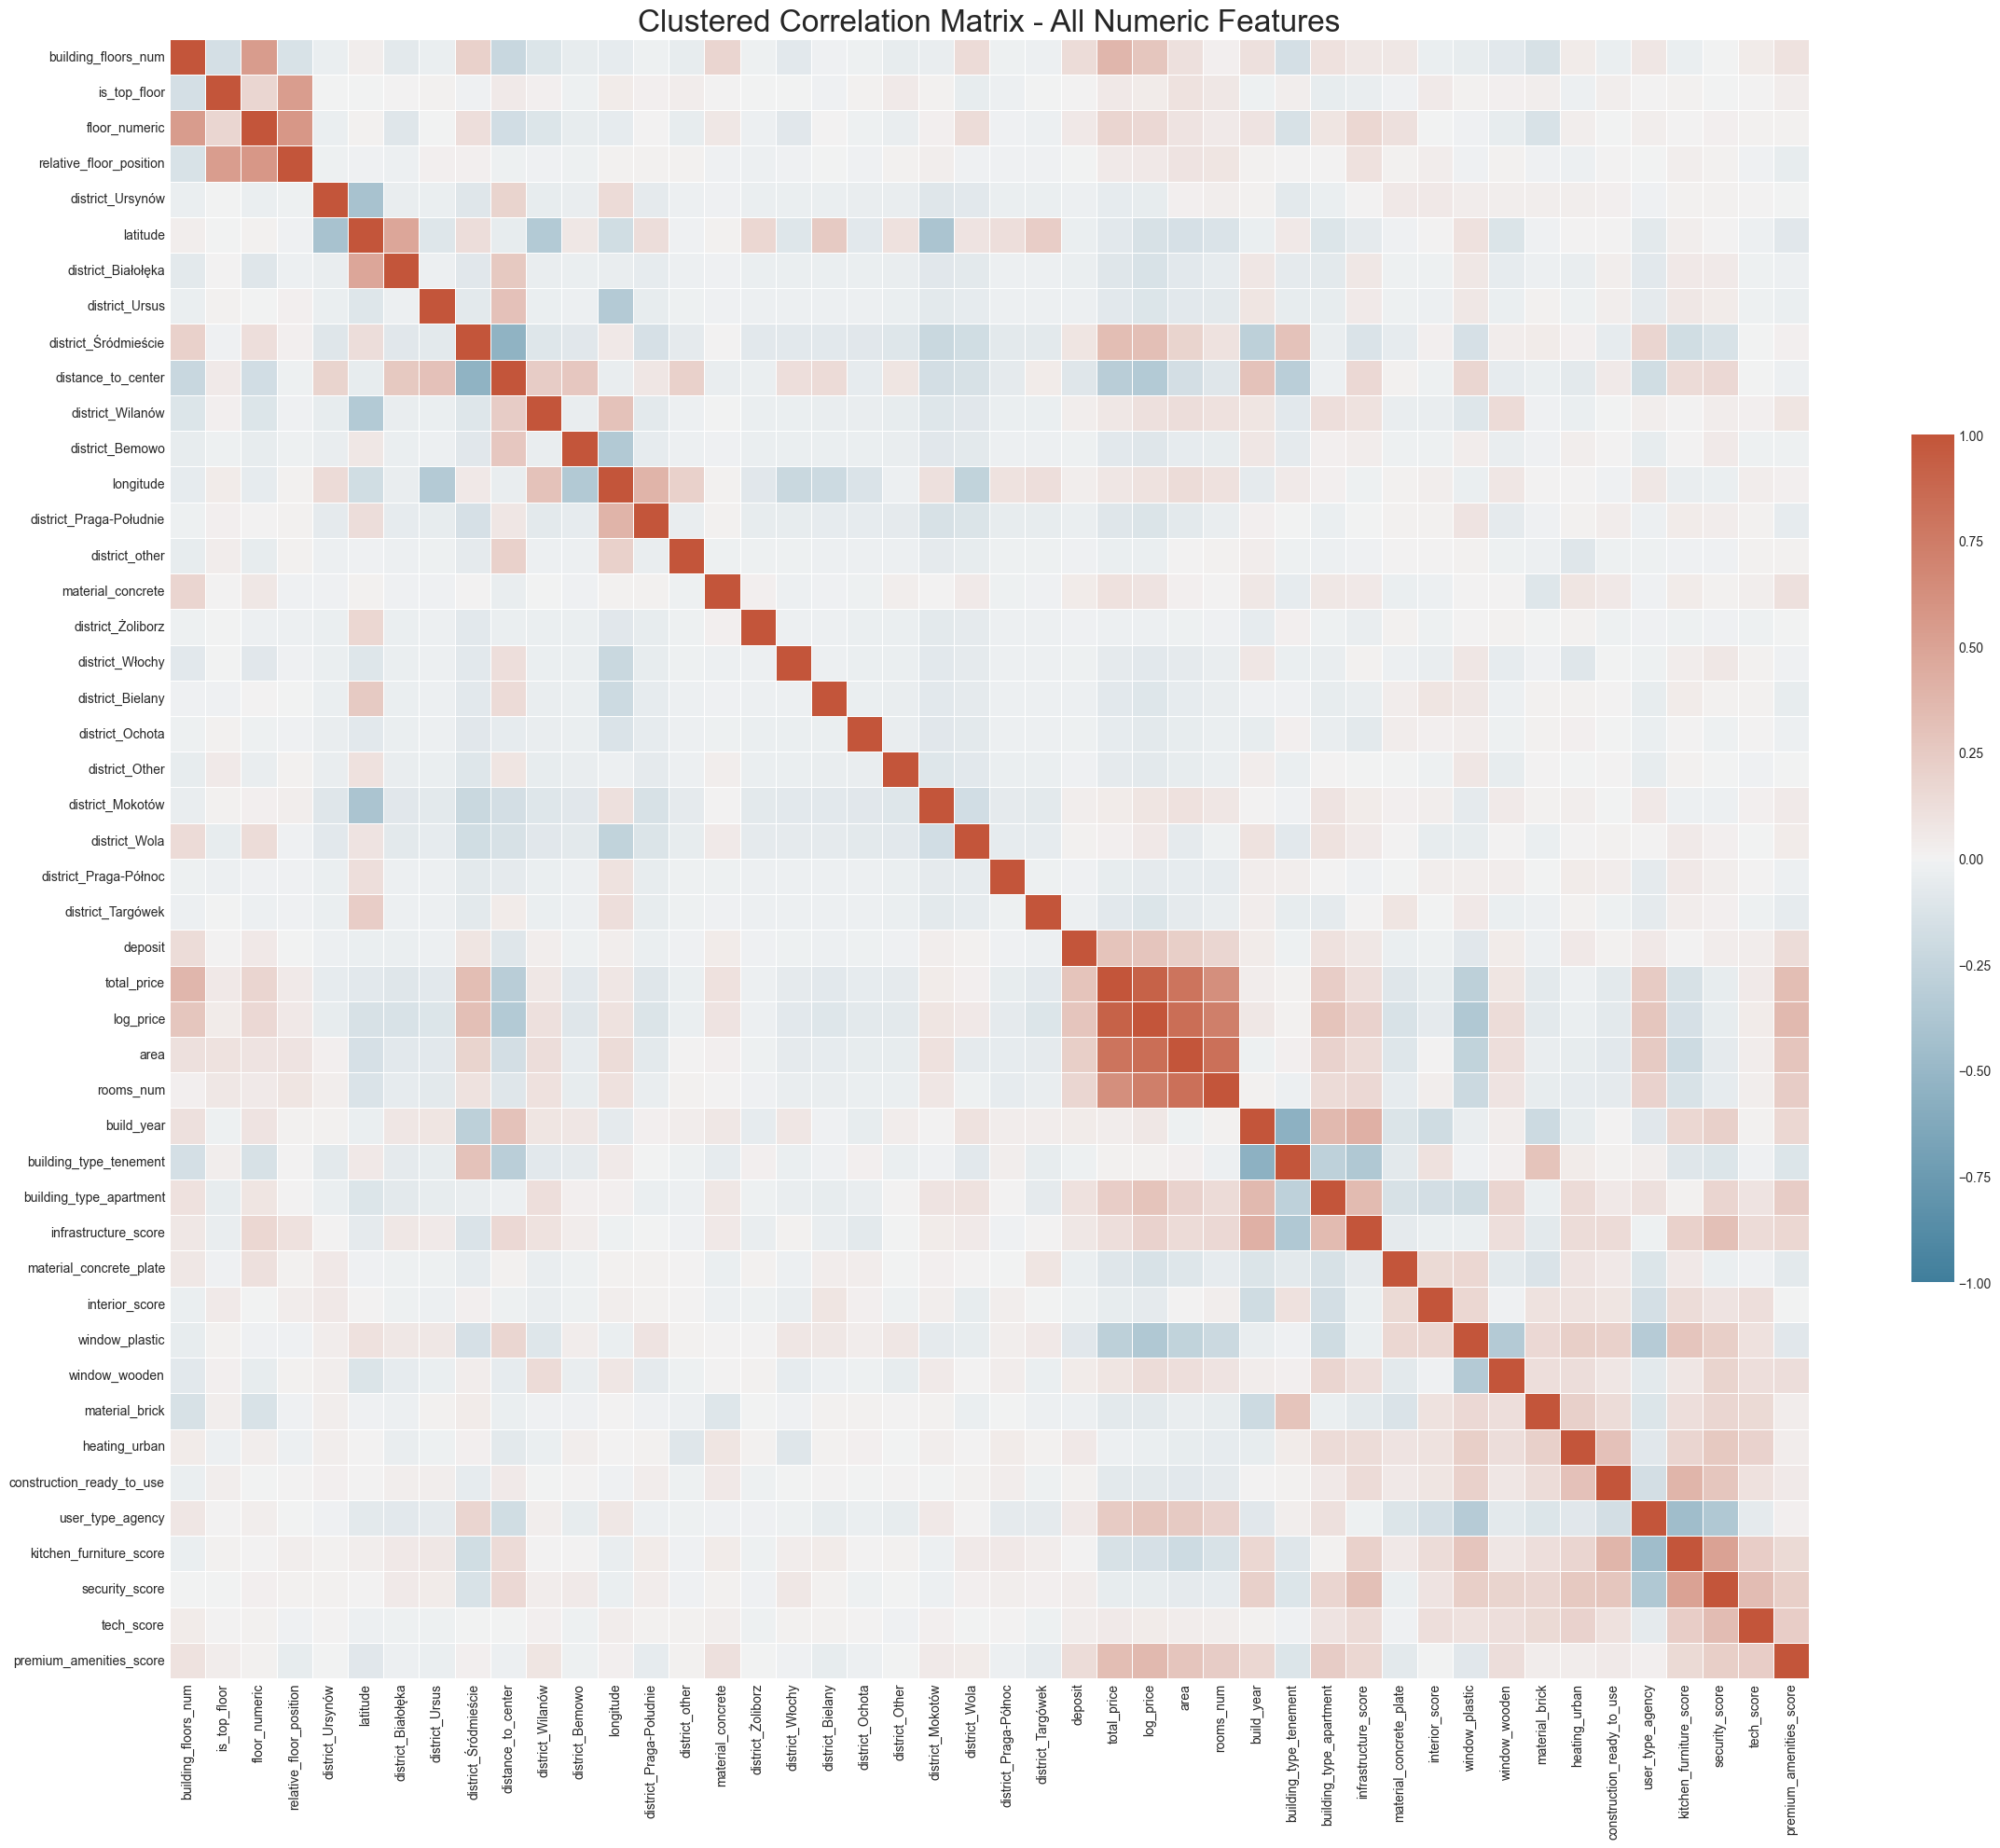

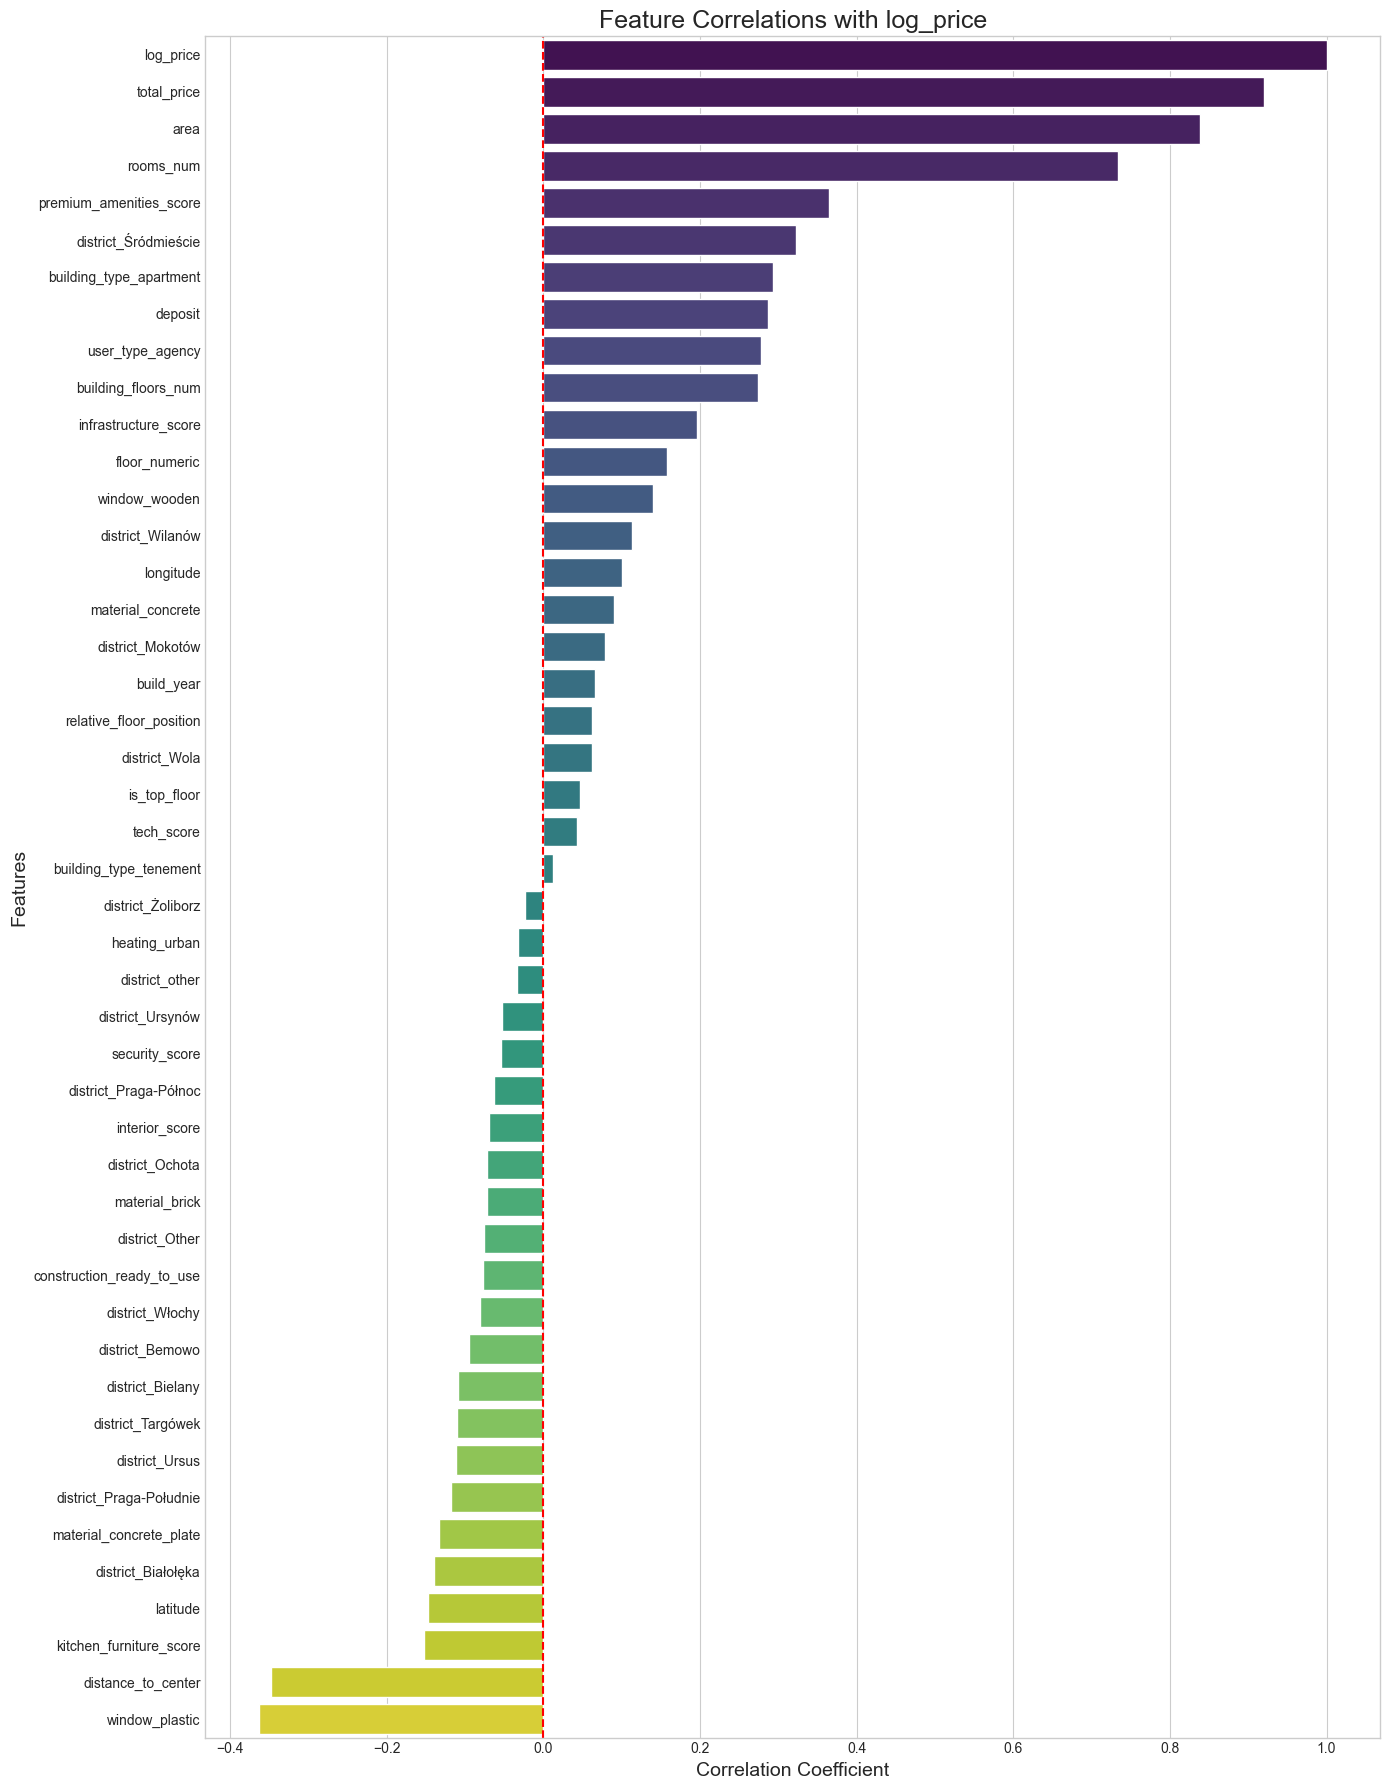

Top 15 features positively correlated with log_price:
log_price                  1.000000
total_price                0.919912
area                       0.838260
rooms_num                  0.733432
premium_amenities_score    0.364791
district_Śródmieście       0.322204
building_type_apartment    0.293268
deposit                    0.287104
user_type_agency           0.277808
building_floors_num        0.273869
infrastructure_score       0.195945
floor_numeric              0.157807
window_wooden              0.140260
district_Wilanów           0.113454
longitude                  0.100613
Name: log_price, dtype: float64

Features negatively correlated with log_price:
district_Bielany          -0.108890
district_Targówek         -0.109800
district_Ursus            -0.111113
district_Praga-Południe   -0.117492
material_concrete_plate   -0.132857
district_Białołęka        -0.139678
latitude                  -0.146820
kitchen_furniture_score   -0.151894
distance_to_center        -0.347915
wi

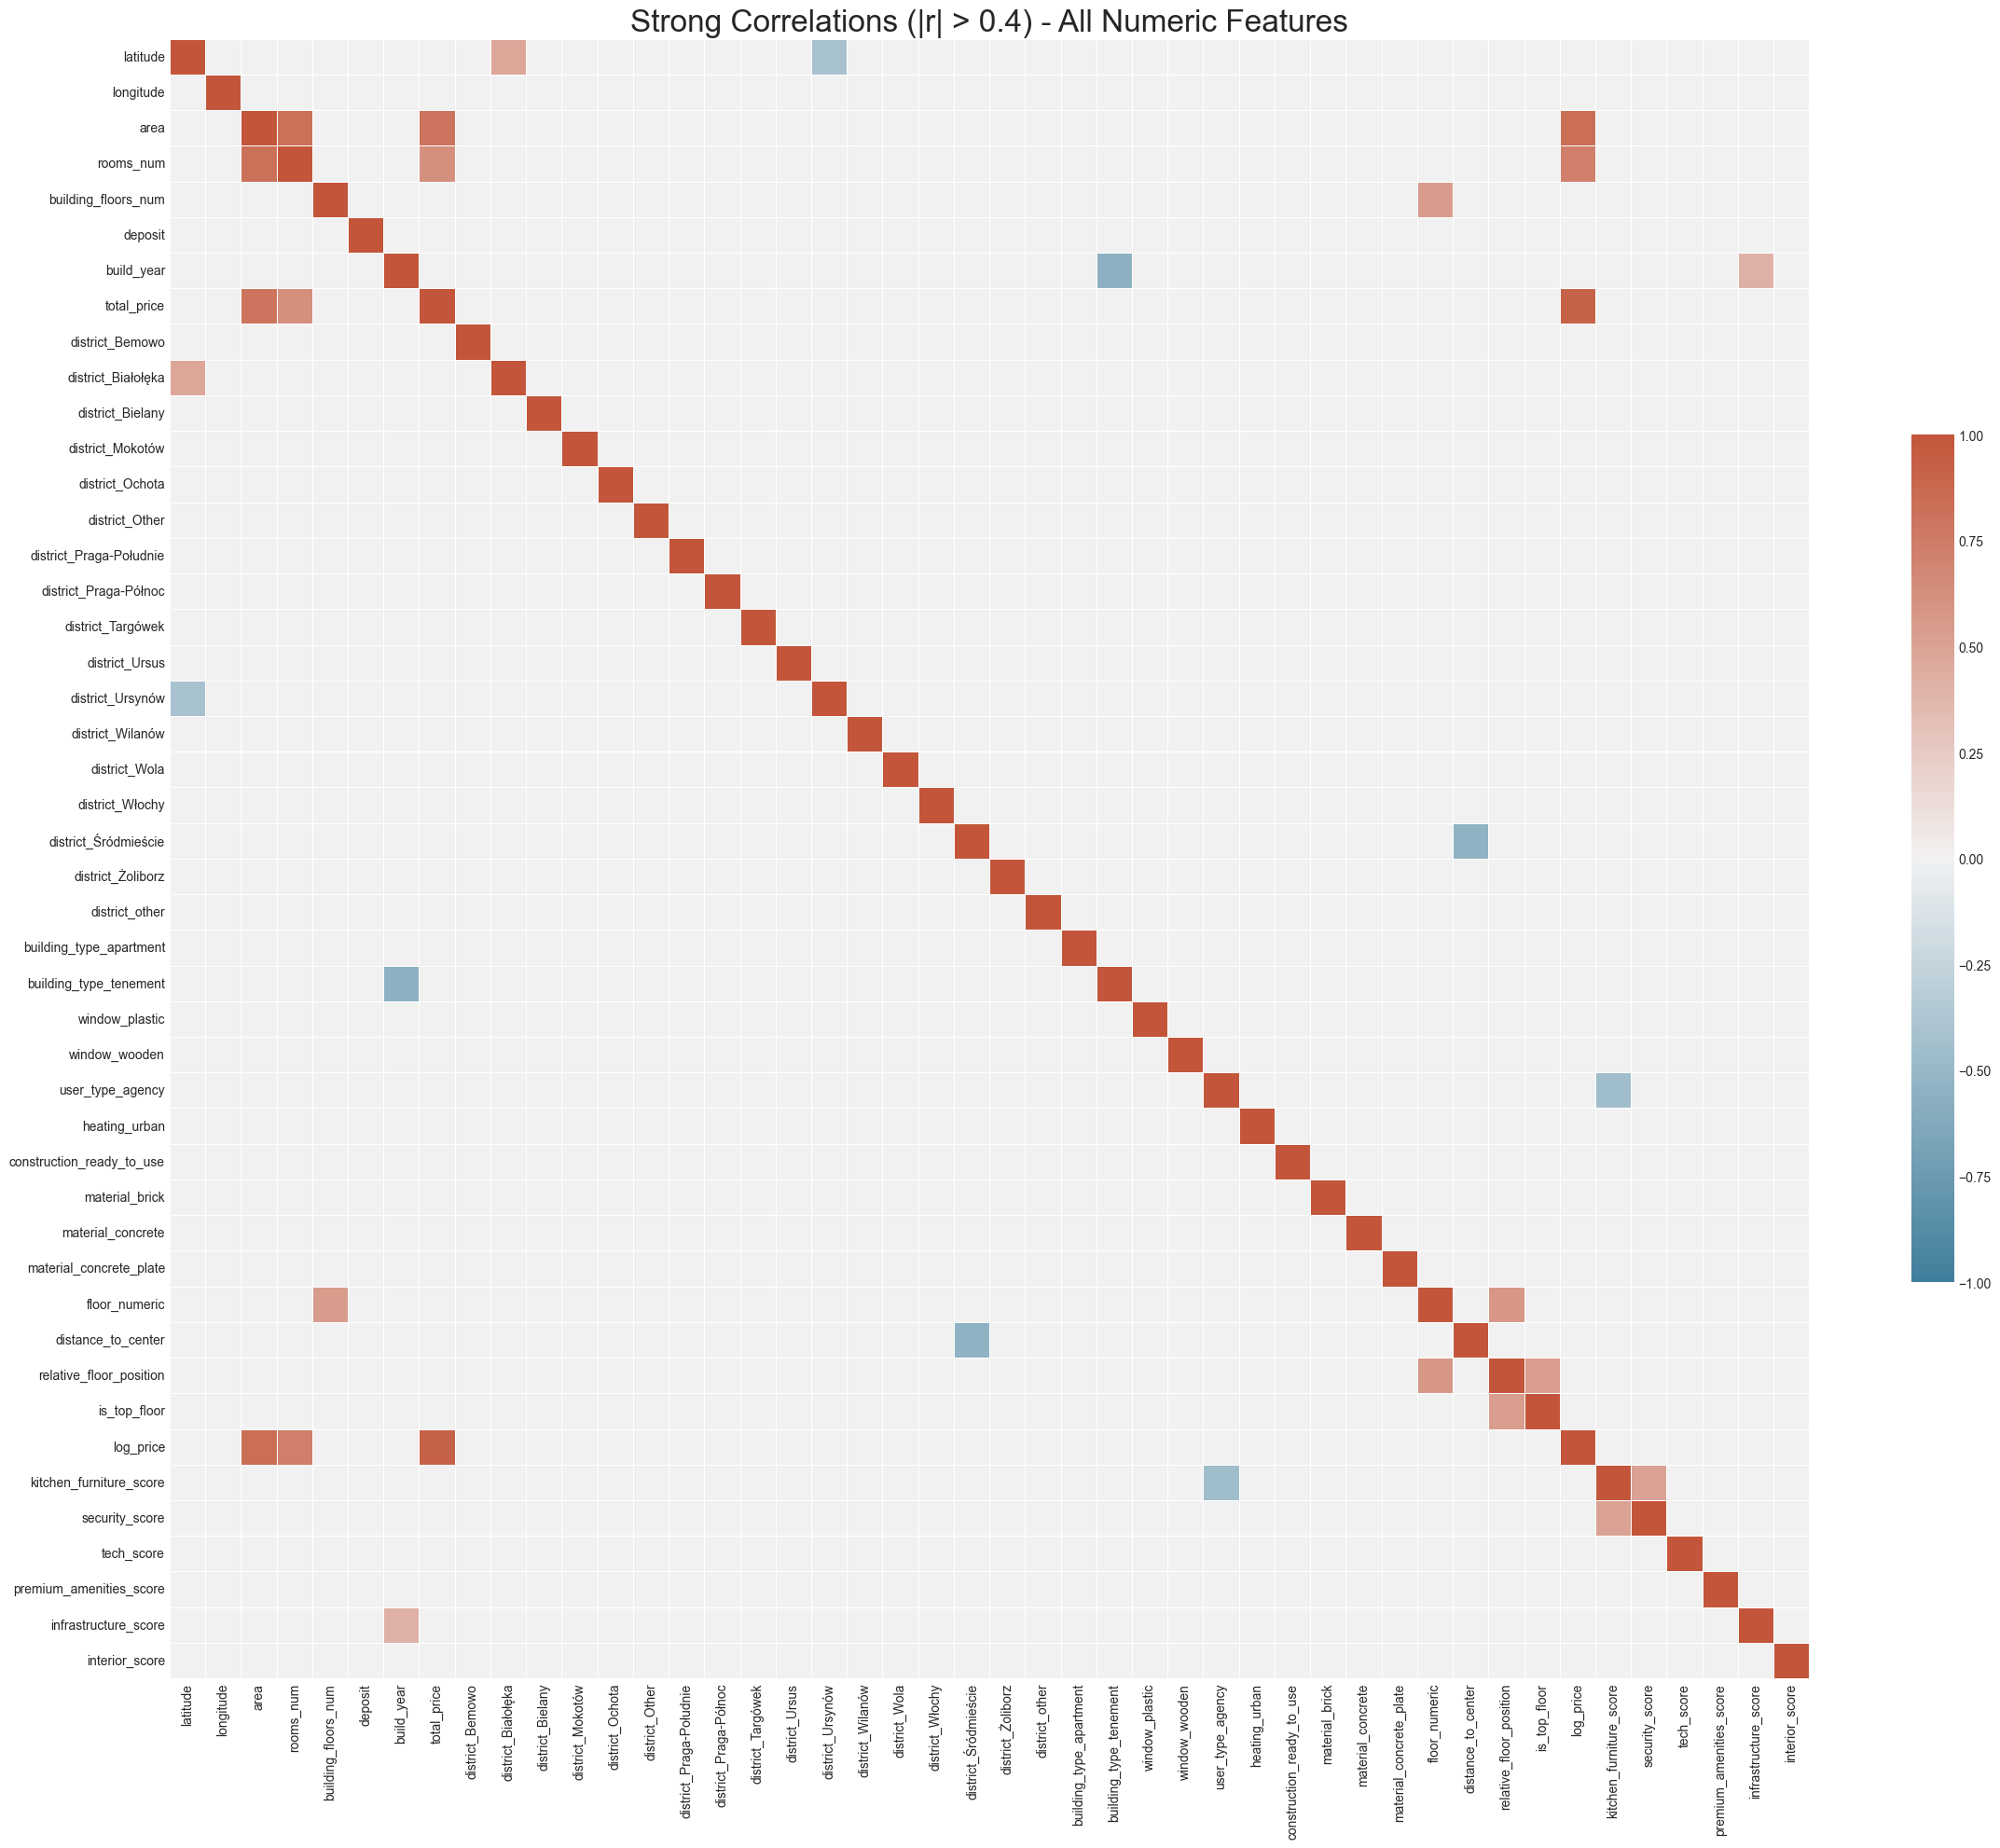

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings('ignore')

# Get numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(24, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap,
            vmax=1, vmin=-1, center=0,
            square=True, linewidths=0.5, 
            cbar_kws={"shrink": .5})

# Add title and adjust layout
plt.title('Correlation Matrix of All Numeric Features', fontsize=24)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a clustered correlation matrix for better pattern visibility
plt.figure(figsize=(24, 20))

# Convert correlation matrix to distance matrix
dissimilarity = 1 - np.abs(correlation_matrix)
distance_matrix = squareform(dissimilarity)

# Perform hierarchical clustering
Z = hierarchy.linkage(distance_matrix, 'ward')
order = hierarchy.dendrogram(Z, no_plot=True)['leaves']

# Reorder the correlation matrix
reordered_corr = correlation_matrix.iloc[order, order]

# Draw the clustered heatmap
sns.heatmap(reordered_corr, cmap=cmap,
            vmax=1, vmin=-1, center=0,
            square=True, linewidths=0.5,
            cbar_kws={"shrink": .5})

plt.title('Clustered Correlation Matrix - All Numeric Features', fontsize=24)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save the clustered figure
plt.savefig('clustered_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a correlation matrix with target variable (log_price)
# Sort the correlations with log_price and create a horizontal bar plot
target_corr = correlation_matrix['log_price'].sort_values(ascending=False)

plt.figure(figsize=(14, 18))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='viridis')
plt.title('Feature Correlations with log_price', fontsize=18)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()

# Save the target correlation figure
plt.savefig('target_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Display top feature correlations with log_price
print("Top 15 features positively correlated with log_price:")
print(target_corr.head(15))

print("\nFeatures negatively correlated with log_price:")
print(target_corr.tail(10))

# Find the strongest feature pairs (excluding correlations with self)
feature_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        col_i = correlation_matrix.columns[i]
        col_j = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        feature_pairs.append((col_i, col_j, corr_value))

# Sort by absolute correlation
feature_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# Print the top 30 strongest correlations
print("\nTop 30 strongest feature correlations:")
for i, (col_i, col_j, corr_value) in enumerate(feature_pairs[:30]):
    print(f"{i+1}. {col_i} - {col_j}: {corr_value:.6f}")

# Create a filtered correlation matrix showing only strong correlations
threshold = 0.4  # Adjust based on your data
strong_corr = correlation_matrix.copy()
strong_corr[np.abs(strong_corr) < threshold] = 0

plt.figure(figsize=(24, 20))
sns.heatmap(strong_corr, cmap=cmap,
            vmax=1, vmin=-1, center=0,
            square=True, linewidths=0.5, 
            cbar_kws={"shrink": .5})

plt.title(f'Strong Correlations (|r| > {threshold}) - All Numeric Features', fontsize=24)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save the filtered correlation matrix
plt.savefig('strong_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

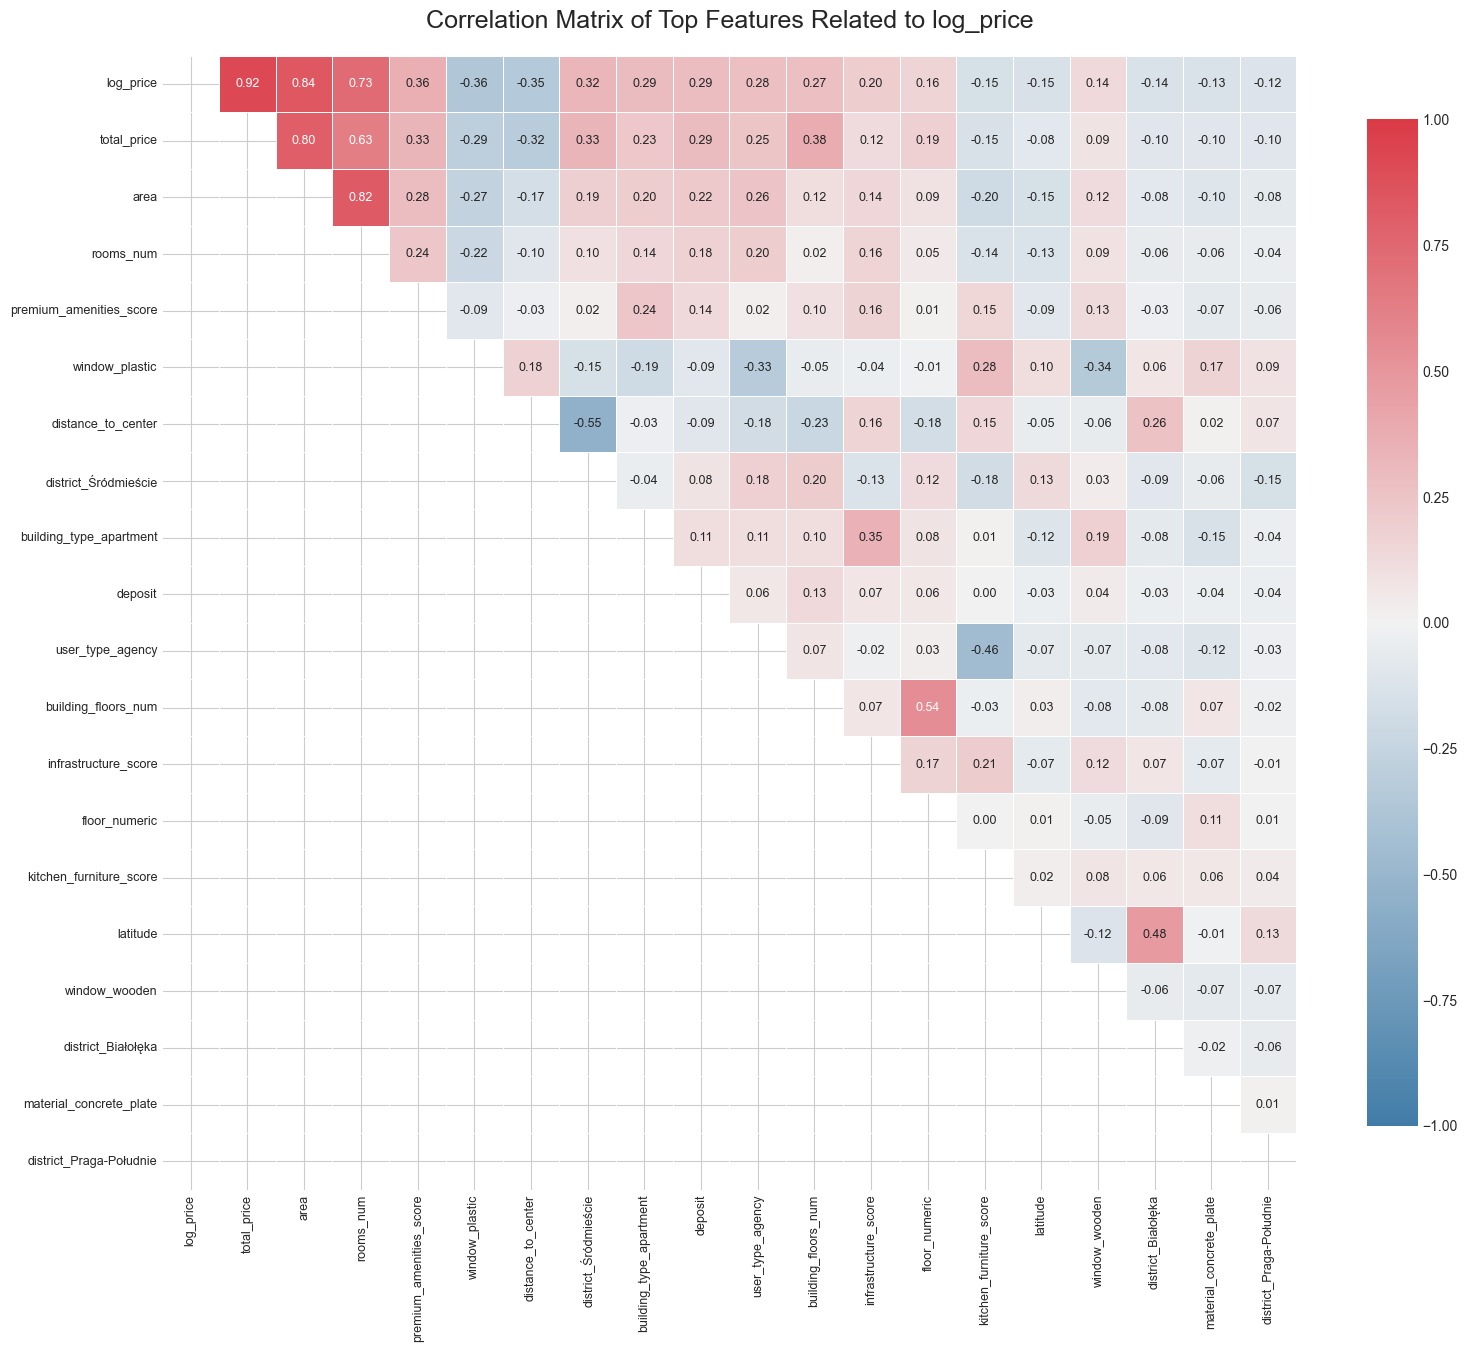

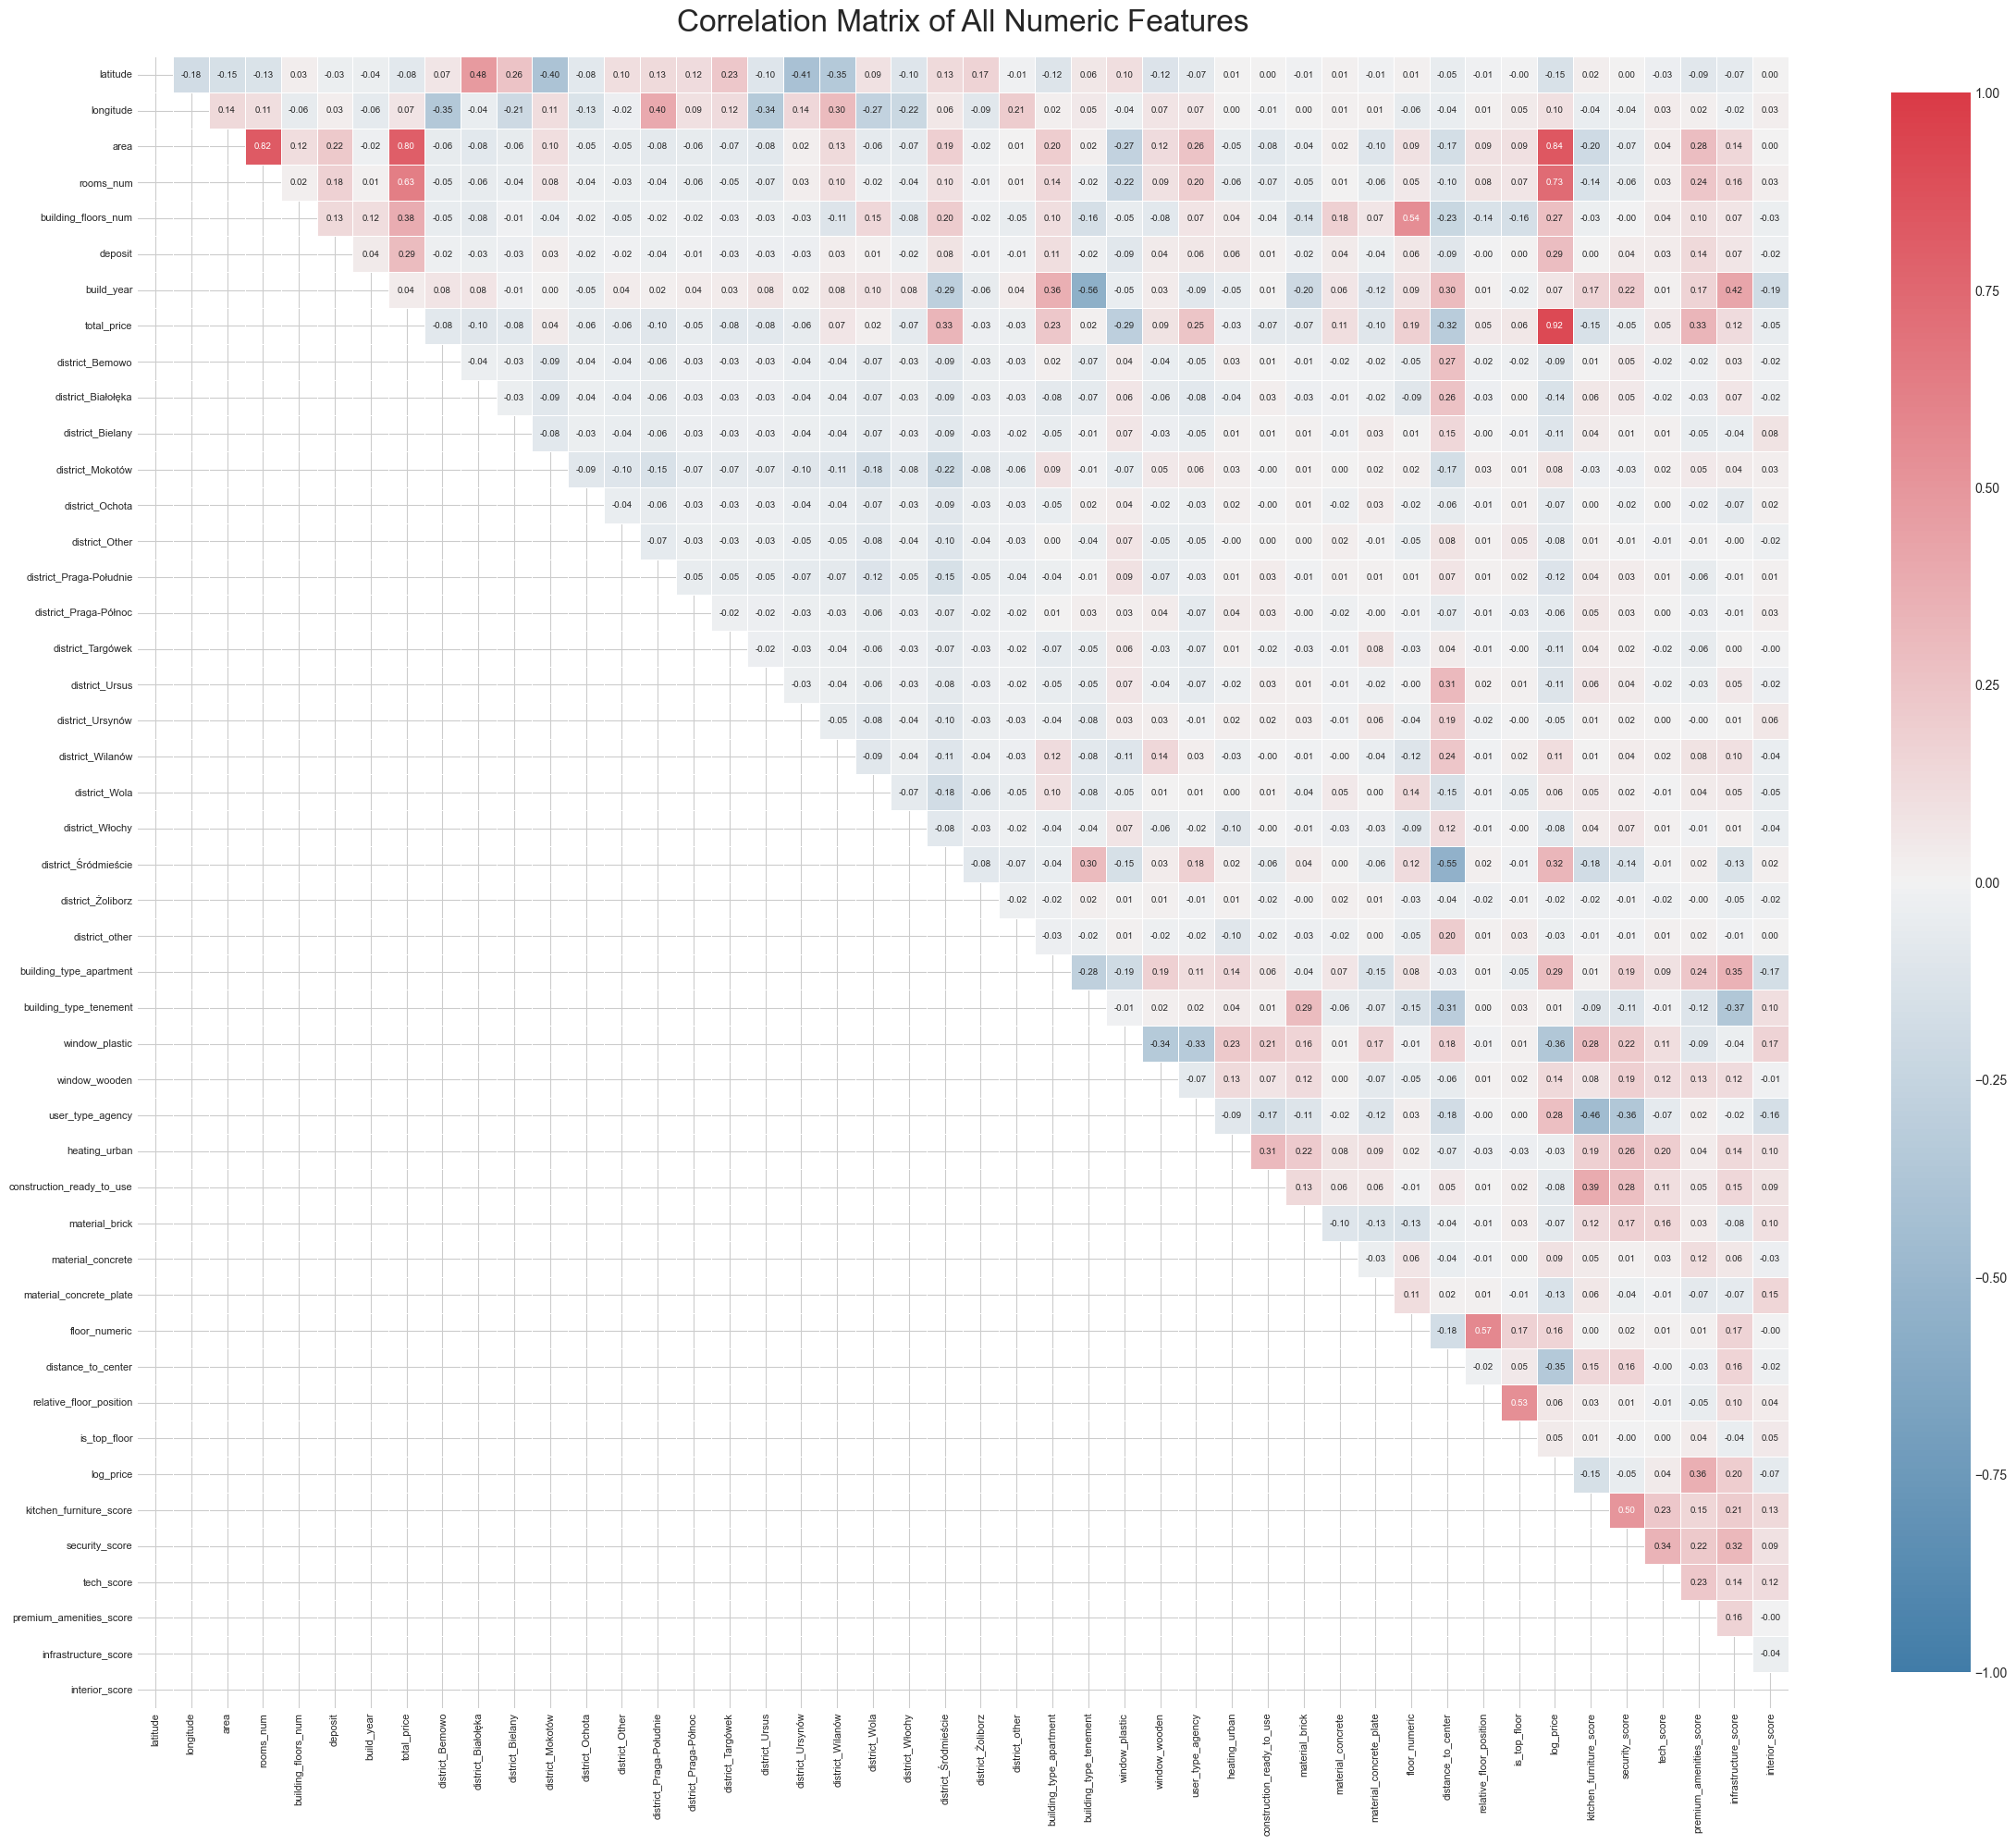

Top 15 features correlated with log_price:
log_price: 1.0000
total_price: 0.9199
area: 0.8383
rooms_num: 0.7334
premium_amenities_score: 0.3648
district_Śródmieście: 0.3222
building_type_apartment: 0.2933
deposit: 0.2871
user_type_agency: 0.2778
building_floors_num: 0.2739
infrastructure_score: 0.1959
floor_numeric: 0.1578
window_wooden: 0.1403
district_Wilanów: 0.1135
longitude: 0.1006

Strongest feature pair correlations (excluding self-correlations):
1. total_price - log_price: 0.9199
2. area - log_price: 0.8383
3. area - rooms_num: 0.8247
4. area - total_price: 0.8016
5. rooms_num - log_price: 0.7334
6. rooms_num - total_price: 0.6262
7. floor_numeric - relative_floor_position: 0.5719
8. build_year - building_type_tenement: -0.5560
9. district_Śródmieście - distance_to_center: -0.5460
10. building_floors_num - floor_numeric: 0.5438
11. relative_floor_position - is_top_floor: 0.5317
12. kitchen_furniture_score - security_score: 0.5039
13. latitude - district_Białołęka: 0.4801
14. us

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Get numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Get the top features correlated with log_price
target_corr = abs(correlation_matrix['log_price']).sort_values(ascending=False)
top_features = list(target_corr.index[:20])  # Top 20 features

# Ensure log_price is included and at the top
if 'log_price' in top_features and top_features[0] != 'log_price':
    top_features.remove('log_price')
    top_features.insert(0, 'log_price')

# Create a reduced correlation matrix with only the top features
reduced_corr = correlation_matrix.loc[top_features, top_features]

# Set up the matplotlib figure
plt.figure(figsize=(16, 14))

# Create a mask for the lower triangle (to match your example's upper triangle display)
mask = np.zeros_like(reduced_corr, dtype=bool)
mask[np.tril_indices_from(mask, k=0)] = True  # Include diagonal in mask

# Create a custom colormap that matches your example (blue-white-red)
cmap = sns.diverging_palette(240, 10, as_cmap=True)  # Blue to red

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    reduced_corr, 
    mask=mask,
    annot=True,  # Show the correlation values
    fmt='.2f',   # Format as 2 decimal places
    cmap=cmap,   # Blue-white-red colormap
    vmax=1.0, 
    vmin=-1.0,
    center=0,
    square=True, 
    linewidths=0.5,
    annot_kws={"size": 9},  # Adjust text size
    cbar_kws={"shrink": .8, "orientation": "vertical"}  # Vertical color bar on right
)

plt.title('Correlation Matrix of Top Features Related to log_price', fontsize=18, pad=20)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# For the full correlation matrix
plt.figure(figsize=(24, 22))

# Create a mask for the lower triangle
full_mask = np.zeros_like(correlation_matrix, dtype=bool)
full_mask[np.tril_indices_from(full_mask, k=0)] = True  # Include diagonal

# Draw the heatmap
sns.heatmap(
    correlation_matrix, 
    mask=full_mask,
    annot=True,  # Show the correlation values
    fmt='.2f',   # Format as 2 decimal places
    cmap=cmap,   # Blue-white-red colormap
    vmax=1.0, 
    vmin=-1.0,
    center=0,
    square=True, 
    linewidths=0.5,
    annot_kws={"size": 7},  # Adjust text size
    cbar_kws={"shrink": .8, "orientation": "vertical"}
)

plt.title('Correlation Matrix of All Numeric Features', fontsize=24, pad=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Generate a text summary of the most important correlations
print("Top 15 features correlated with log_price:")
for feature, corr in correlation_matrix['log_price'].sort_values(ascending=False).head(15).items():
    print(f"{feature}: {corr:.4f}")

print("\nStrongest feature pair correlations (excluding self-correlations):")
# Find the strongest correlations excluding self-correlations
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        col_i = correlation_matrix.columns[i]
        col_j = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        corr_pairs.append((col_i, col_j, corr_value))

# Sort by absolute correlation
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# Print top 20 correlations
for i, (col_i, col_j, corr_value) in enumerate(corr_pairs[:20]):
    print(f"{i+1}. {col_i} - {col_j}: {corr_value:.4f}")

In [49]:
# Simple correlation analysis to find the top 30 highly correlated feature pairs
import pandas as pd
import numpy as np
from IPython.display import display

# Calculate the correlation matrix from the current dataframe
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

# Create a mask for the upper triangle to avoid duplicates and self-correlations
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Get the correlations excluding self-correlations
high_corr_pairs = correlation_matrix.abs().where(~mask).stack().sort_values(ascending=False)

# Display top 30 correlated pairs
print("Highly correlated feature pairs (potential redundancy):")
display(high_corr_pairs)


Highly correlated feature pairs (potential redundancy):


log_price                  total_price                  0.919912
                           area                         0.838260
rooms_num                  area                         0.824685
total_price                area                         0.801639
log_price                  rooms_num                    0.733432
total_price                rooms_num                    0.626247
relative_floor_position    floor_numeric                0.571897
building_type_tenement     build_year                   0.556003
distance_to_center         district_Śródmieście         0.546031
floor_numeric              building_floors_num          0.543797
is_top_floor               relative_floor_position      0.531728
security_score             kitchen_furniture_score      0.503890
district_Białołęka         latitude                     0.480135
kitchen_furniture_score    user_type_agency             0.456753
infrastructure_score       build_year                   0.418362
district_Ursynów         

Average Price per Square Meter by District:
   district_standardized  avg_price_per_sqm  count
14           Śródmieście         125.734106   1123
12                  Wola         119.213374    771
7           Praga-Północ         101.998079    133
13                Włochy         101.330794    172
3                Mokotów         100.227669   1083
15              Żoliborz          99.220972    161
11               Wilanów          98.122359    299
4                 Ochota          94.635667    215
9                  Ursus          93.635286    150
6         Praga-Południe          93.397881    542
5                  Other          93.181179    386
0                 Bemowo          88.814544    220
8               Targówek          87.125925    141
2                Bielany          86.345767    190
1              Białołęka          82.568003    211
10               Ursynów          82.210578    257


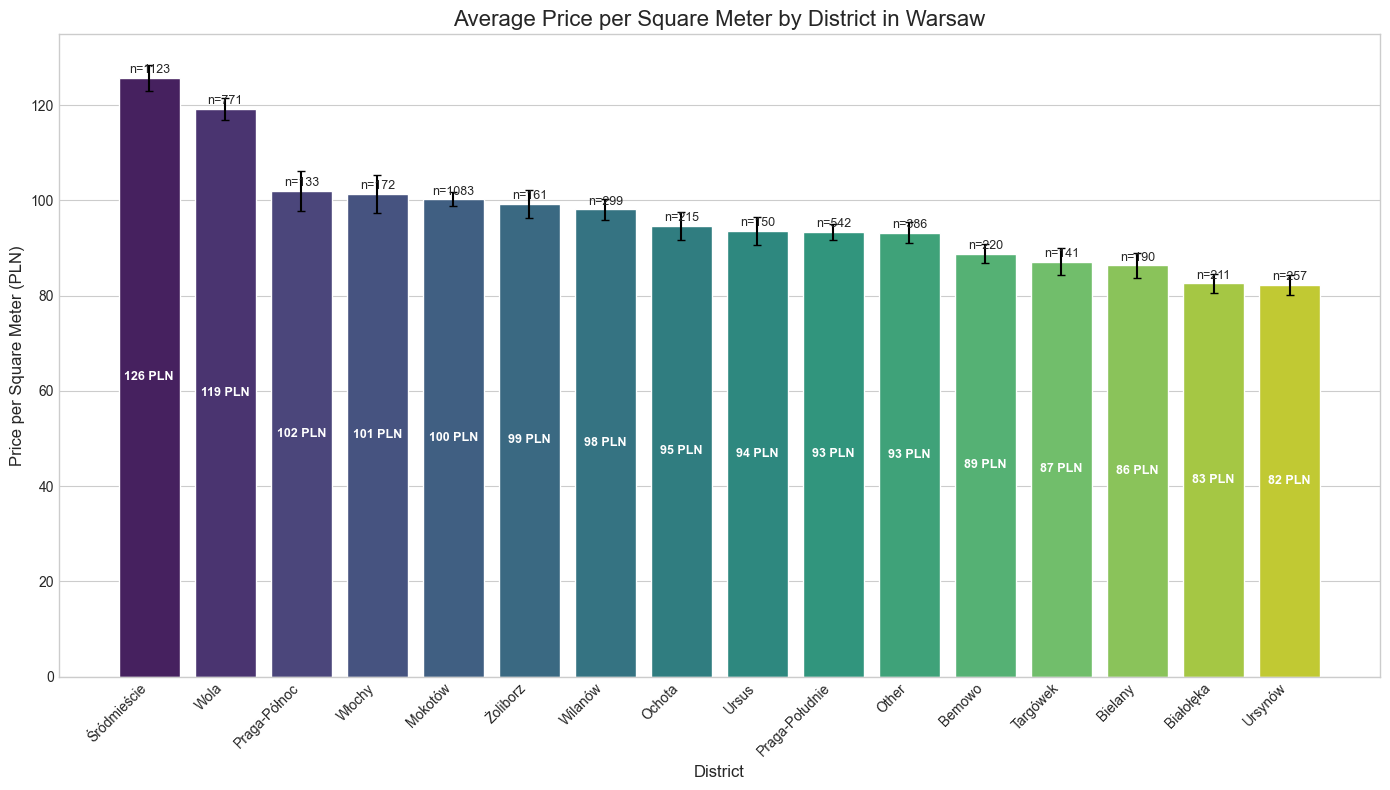


Detailed Price per Square Meter Statistics by District:
   district_standardized  avg_price_per_sqm  count    std  ci_95
14           Śródmieście             125.73   1123  46.26   2.71
12                  Wola             119.21    771  32.00   2.26
7           Praga-Północ             102.00    133  24.31   4.13
13                Włochy             101.33    172  26.56   3.97
3                Mokotów             100.23   1083  24.08   1.43
15              Żoliborz              99.22    161  19.06   2.94
11               Wilanów              98.12    299  18.81   2.13
4                 Ochota              94.64    215  21.31   2.85
9                  Ursus              93.64    150  18.09   2.90
6         Praga-Południe              93.40    542  19.17   1.61
5                  Other              93.18    386  22.18   2.21
0                 Bemowo              88.81    220  15.45   2.04
8               Targówek              87.13    141  17.34   2.86
2                Bielany         

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate price per square meter by district
# We need to convert from log_price back to actual price first
df['price'] = np.exp(df['log_price'])
df['price_per_sqm'] = df['price'] / df['area']

# Group by district and calculate mean price per square meter
district_prices = df.groupby('district_standardized')['price_per_sqm'].agg(['mean', 'count', 'std'])
district_prices = district_prices.reset_index()
district_prices = district_prices.rename(columns={'mean': 'avg_price_per_sqm'})

# Sort by average price per square meter in descending order
district_prices = district_prices.sort_values('avg_price_per_sqm', ascending=False)

# Calculate 95% confidence intervals
district_prices['ci_95'] = 1.96 * district_prices['std'] / np.sqrt(district_prices['count'])

# Display the results
print("Average Price per Square Meter by District:")
print(district_prices[['district_standardized', 'avg_price_per_sqm', 'count']])

# Create a bar plot
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
ax = sns.barplot(x='district_standardized', y='avg_price_per_sqm', data=district_prices, 
                palette='viridis', order=district_prices['district_standardized'])

# Add error bars
plt.errorbar(x=np.arange(len(district_prices)), y=district_prices['avg_price_per_sqm'], 
             yerr=district_prices['ci_95'], fmt='none', color='black', capsize=3)

# Add count labels on top of bars
for i, row in enumerate(district_prices.itertuples()):
    ax.text(i, row.avg_price_per_sqm + 1, f'n={row.count}', ha='center', fontsize=9)

# Format the plot
plt.title('Average Price per Square Meter by District in Warsaw', fontsize=16)
plt.xlabel('District', fontsize=12)
plt.ylabel('Price per Square Meter (PLN)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add price labels on the bars
for i, v in enumerate(district_prices['avg_price_per_sqm']):
    ax.text(i, v/2, f'{v:.0f} PLN', ha='center', va='center', fontsize=9, color='white', fontweight='bold')

plt.show()

# Create a table for detailed information
detailed_table = district_prices.copy()
detailed_table['avg_price_per_sqm'] = detailed_table['avg_price_per_sqm'].round(2)
detailed_table['std'] = detailed_table['std'].round(2)
detailed_table['ci_95'] = detailed_table['ci_95'].round(2)

# Display the detailed table
print("\nDetailed Price per Square Meter Statistics by District:")
print(detailed_table[['district_standardized', 'avg_price_per_sqm', 'count', 'std', 'ci_95']])

# Optional: Calculate relative price differences compared to the Warsaw average
warsaw_avg = df['price_per_sqm'].mean()
district_prices['relative_to_avg'] = (district_prices['avg_price_per_sqm'] / warsaw_avg - 1) * 100

print(f"\nWarsaw average price per square meter: {warsaw_avg:.2f} PLN")
print("\nDistrict prices relative to Warsaw average (%):")
for district, rel_price in zip(district_prices['district_standardized'], district_prices['relative_to_avg']):
    sign = "+" if rel_price > 0 else ""
    print(f"{district}: {sign}{rel_price:.2f}%")

In [51]:
# Fix non-numeric columns in the dataset by converting boolean columns to integers

# First, check which columns are boolean type
bool_columns = df.select_dtypes(include=['bool']).columns.tolist()

if bool_columns:
    print(f"Converting {len(bool_columns)} boolean columns to integers:")
    print(bool_columns)
    
    # Convert boolean columns to integers (0/1)
    for col in bool_columns:
        df[col] = df[col].astype(int)
    
    print("Conversion complete. All boolean columns are now integers.")
else:
    # If there are no boolean columns, check which district columns need fixing
    district_columns = [col for col in df.columns if col.startswith('district_') and col != 'district_standardized']
    
    print(f"Ensuring {len(district_columns)} district columns are integers:")
    # Convert district columns to integers explicitly
    for col in district_columns:
        if df[col].dtype != 'int64':
            original_dtype = df[col].dtype
            df[col] = df[col].astype(int)
            print(f"Converted {col} from {original_dtype} to int")
        else:
            print(f"{col} is already int64 type")

# Verify the conversion
print("\nUpdated data types:")
for col in [c for c in df.columns if c.startswith('district_') and c != 'district_standardized']:
    print(f"{col}: {df[col].dtype}")

# Now you can proceed with your regression analysis using the fixed dataset

Ensuring 17 district columns are integers:
district_Bemowo is already int64 type
district_Białołęka is already int64 type
district_Bielany is already int64 type
district_Mokotów is already int64 type
district_Ochota is already int64 type
district_Other is already int64 type
district_Praga-Południe is already int64 type
district_Praga-Północ is already int64 type
district_Targówek is already int64 type
district_Ursus is already int64 type
district_Ursynów is already int64 type
district_Wilanów is already int64 type
district_Wola is already int64 type
district_Włochy is already int64 type
district_Śródmieście is already int64 type
district_Żoliborz is already int64 type
district_other is already int64 type

Updated data types:
district_Bemowo: int64
district_Białołęka: int64
district_Bielany: int64
district_Mokotów: int64
district_Ochota: int64
district_Other: int64
district_Praga-Południe: int64
district_Praga-Północ: int64
district_Targówek: int64
district_Ursus: int64
district_Ursynów

Correlation of amenity scores with prices:
                            price  price_per_sqm  log_price
kitchen_furniture_score -0.146199      -0.009589  -0.151894
security_score          -0.051108      -0.008307  -0.054513
tech_score               0.047672       0.035068   0.043576
premium_amenities_score  0.328474       0.239485   0.364791
infrastructure_score     0.122058       0.024525   0.195945
interior_score          -0.049135      -0.141842  -0.069533

Price impact of amenities:
                         With Amenity (PLN/sqm)  Without Amenity (PLN/sqm)  \
premium_amenities_score              113.287354                  98.095746   
tech_score                           105.407548                 101.669943   
infrastructure_score                 103.458165                 102.360006   
security_score                       103.480224                 102.805516   
kitchen_furniture_score              103.118002                 105.031127   
interior_score                        97.

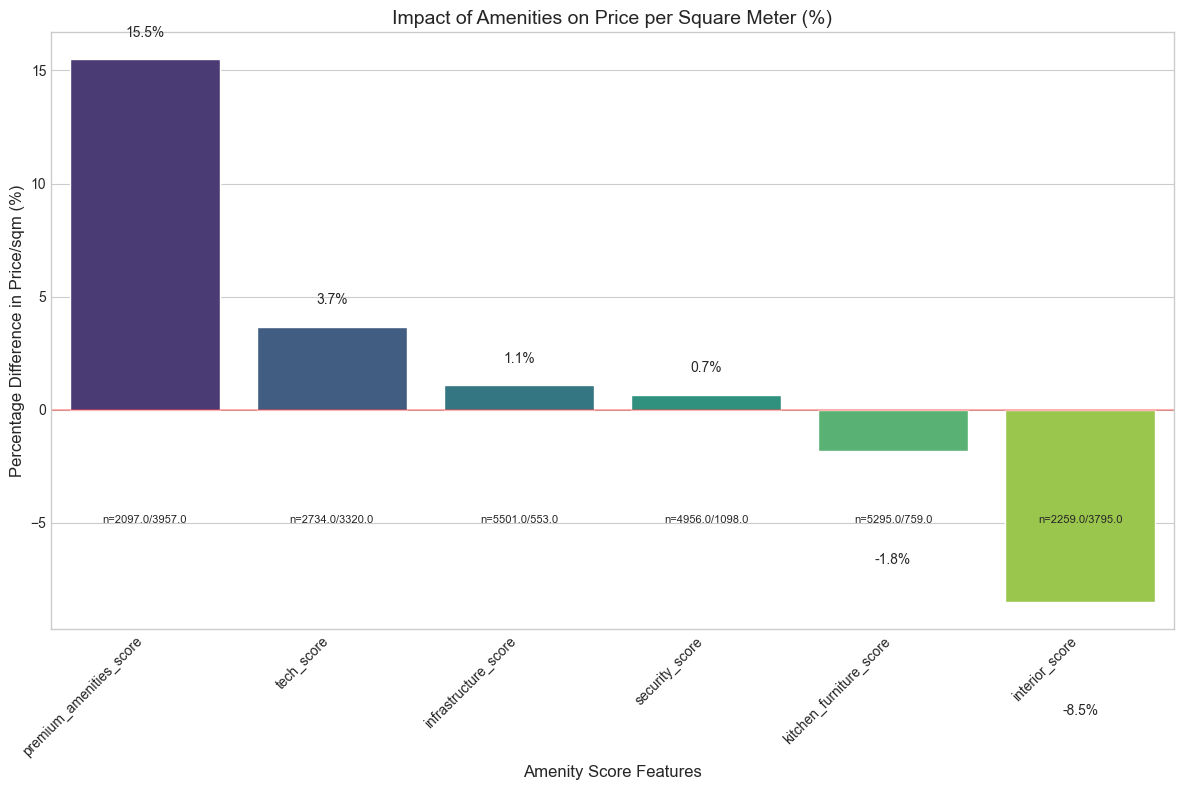

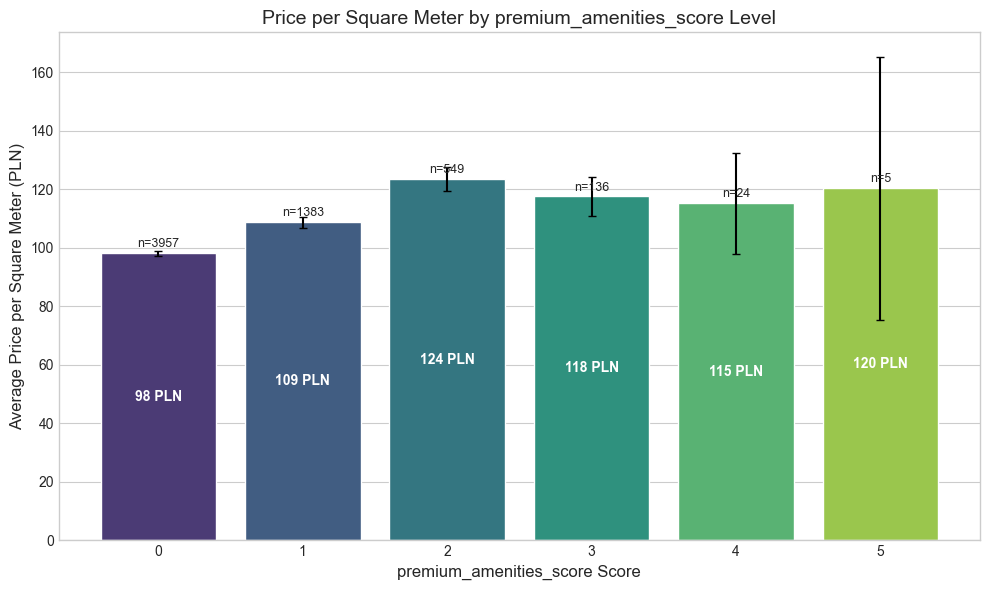

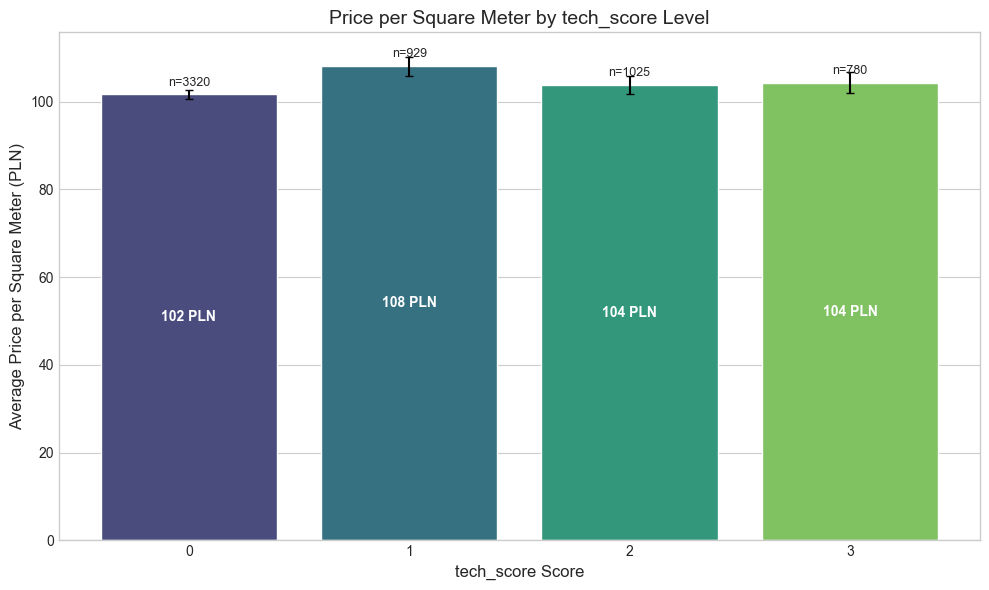

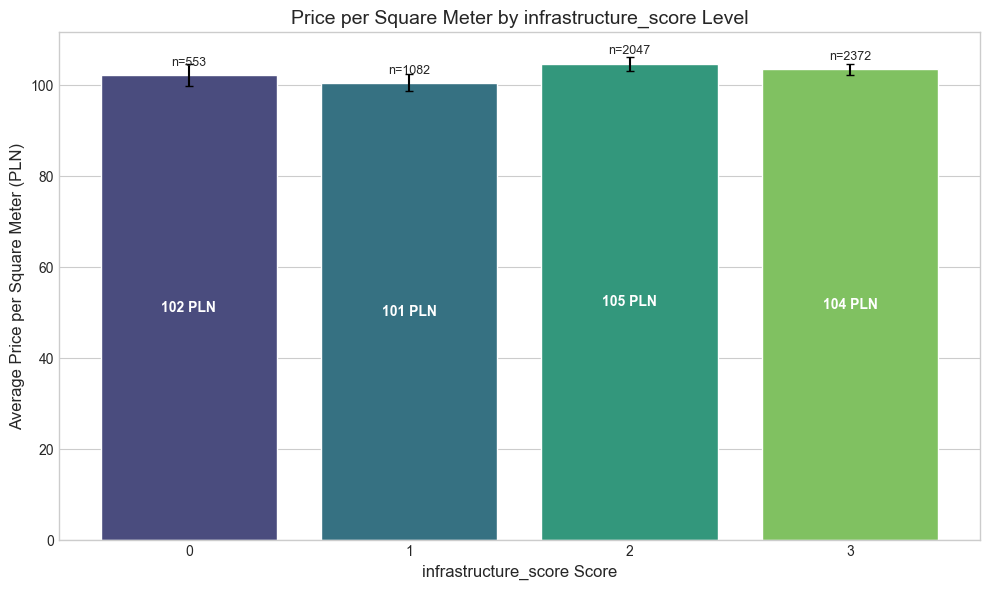


Regression Analysis of Amenity Impact on log_price:
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     2347.
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        14:47:33   Log-Likelihood:                -631.25
No. Observations:                6054   AIC:                             1279.
Df Residuals:                    6046   BIC:                             1332.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

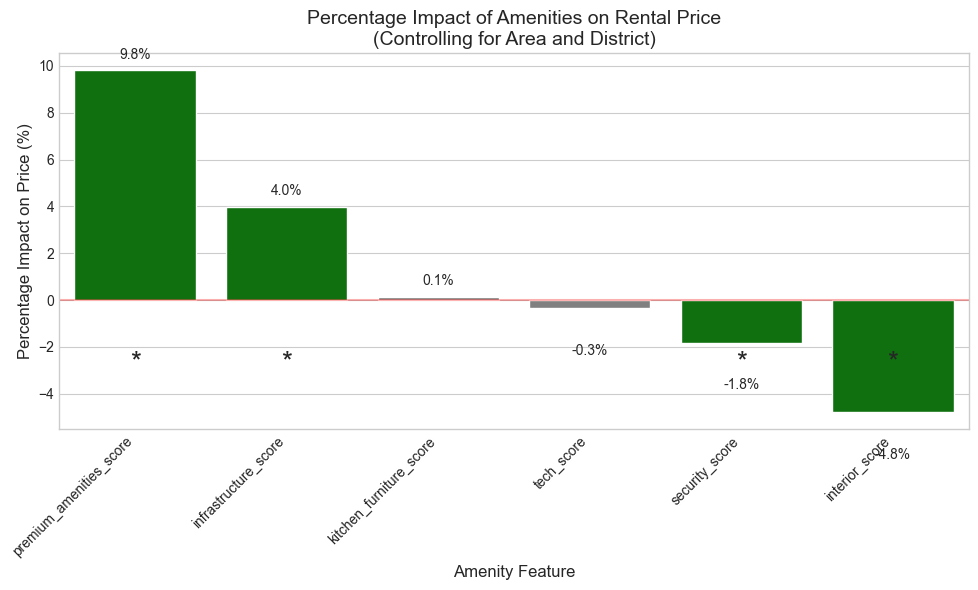

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

# Define the list of amenity score features
amenity_features = [
    'kitchen_furniture_score', 
    'security_score', 
    'tech_score', 
    'premium_amenities_score', 
    'infrastructure_score', 
    'interior_score'
]

# Convert log_price to actual price (if it's not already available)
df['price'] = np.exp(df['log_price'])
df['price_per_sqm'] = df['price'] / df['area']

# 1. Calculate correlation between amenity scores and prices
amenity_price_corr = df[amenity_features + ['price', 'price_per_sqm', 'log_price']].corr()
price_correlations = amenity_price_corr.loc[amenity_features, ['price', 'price_per_sqm', 'log_price']]

print("Correlation of amenity scores with prices:")
print(price_correlations)

# 2. Calculate average price with vs. without each amenity score
# For each amenity score, we'll compare properties with score > 0 vs score = 0
price_impact = pd.DataFrame(index=amenity_features)

for feature in amenity_features:
    # Average price with amenity
    with_amenity = df[df[feature] > 0]['price'].mean()
    with_amenity_per_sqm = df[df[feature] > 0]['price_per_sqm'].mean()
    with_count = df[df[feature] > 0].shape[0]
    
    # Average price without amenity
    without_amenity = df[df[feature] == 0]['price'].mean()
    without_amenity_per_sqm = df[df[feature] == 0]['price_per_sqm'].mean()
    without_count = df[df[feature] == 0].shape[0]
    
    # Calculate differences and percentages
    diff = with_amenity - without_amenity
    diff_per_sqm = with_amenity_per_sqm - without_amenity_per_sqm
    pct_diff = (diff / without_amenity) * 100 if without_amenity > 0 else np.nan
    pct_diff_per_sqm = (diff_per_sqm / without_amenity_per_sqm) * 100 if without_amenity_per_sqm > 0 else np.nan
    
    # Store results
    price_impact.loc[feature, 'With Amenity (PLN)'] = with_amenity
    price_impact.loc[feature, 'Without Amenity (PLN)'] = without_amenity
    price_impact.loc[feature, 'Difference (PLN)'] = diff
    price_impact.loc[feature, 'Percentage Difference (%)'] = pct_diff
    price_impact.loc[feature, 'With Amenity (PLN/sqm)'] = with_amenity_per_sqm
    price_impact.loc[feature, 'Without Amenity (PLN/sqm)'] = without_amenity_per_sqm
    price_impact.loc[feature, 'Difference (PLN/sqm)'] = diff_per_sqm
    price_impact.loc[feature, 'Percentage Difference (PLN/sqm %)'] = pct_diff_per_sqm
    price_impact.loc[feature, 'With Count'] = with_count
    price_impact.loc[feature, 'Without Count'] = without_count

# Sort by percentage difference in price per square meter
price_impact = price_impact.sort_values('Percentage Difference (PLN/sqm %)', ascending=False)

print("\nPrice impact of amenities:")
print(price_impact[['With Amenity (PLN/sqm)', 'Without Amenity (PLN/sqm)', 
                    'Difference (PLN/sqm)', 'Percentage Difference (PLN/sqm %)',
                    'With Count', 'Without Count']])

# 3. Visualize the impact of amenities on price per square meter
plt.figure(figsize=(12, 8))
amenities_sorted = price_impact.index.tolist()
price_diffs = price_impact['Percentage Difference (PLN/sqm %)'].values

# Create bar plot
bars = sns.barplot(x=amenities_sorted, y=price_diffs, palette='viridis')

# Add value labels on bars
for i, v in enumerate(price_diffs):
    if not np.isnan(v):  # Check for NaN values
        bars.text(i, v + (1 if v >= 0 else -5), f'{v:.1f}%', ha='center', fontsize=10)

# Add count labels below x-axis
for i, amenity in enumerate(amenities_sorted):
    with_count = price_impact.loc[amenity, 'With Count']
    without_count = price_impact.loc[amenity, 'Without Count']
    plt.text(i, -5, f'n={with_count}/{without_count}', ha='center', fontsize=8)

plt.title('Impact of Amenities on Price per Square Meter (%)', fontsize=14)
plt.xlabel('Amenity Score Features', fontsize=12)
plt.ylabel('Percentage Difference in Price/sqm (%)', fontsize=12)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Analysis by amenity score level (for the top 3 impactful amenities)
top_amenities = price_impact.head(3).index.tolist()

for amenity in top_amenities:
    # Group by amenity score and calculate average price per sqm
    score_analysis = df.groupby(amenity)['price_per_sqm'].agg(['mean', 'count', 'std']).reset_index()
    score_analysis = score_analysis.rename(columns={'mean': 'avg_price_per_sqm'})
    
    # Calculate 95% confidence intervals
    score_analysis['ci_95'] = 1.96 * score_analysis['std'] / np.sqrt(score_analysis['count'])
    
    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=amenity, y='avg_price_per_sqm', data=score_analysis, palette='viridis')
    
    # Add error bars
    plt.errorbar(x=np.arange(len(score_analysis)), y=score_analysis['avg_price_per_sqm'],
                yerr=score_analysis['ci_95'], fmt='none', color='black', capsize=3)
    
    # Add count labels
    for i, row in enumerate(score_analysis.itertuples()):
        ax.text(i, row.avg_price_per_sqm + 2, f'n={row.count}', ha='center', fontsize=9)
    
    # Add price labels
    for i, v in enumerate(score_analysis['avg_price_per_sqm']):
        ax.text(i, v/2, f'{v:.0f} PLN', ha='center', va='center', color='white', fontweight='bold')
    
    plt.title(f'Price per Square Meter by {amenity} Level', fontsize=14)
    plt.xlabel(f'{amenity} Score', fontsize=12)
    plt.ylabel('Average Price per Square Meter (PLN)', fontsize=12)
    plt.tight_layout()
    plt.show()

# 5. Multiple regression to assess combined impact of amenities
# Modified regression code to handle non-numeric values

# Create a model with amenity features controlling for area
X_base = df[amenity_features + ['area']].copy()  

# Add district dummy variables - using pd.get_dummies to properly create dummies
district_dummies = pd.get_dummies(df['district_standardized'], prefix='district', drop_first=True)

# Combine features and district dummies
X_combined = pd.concat([X_base, district_dummies], axis=1)

# Check for non-numeric columns before regression
non_numeric_cols = X_combined.select_dtypes(exclude=['number']).columns.tolist()
if non_numeric_cols:
    print(f"Warning: Removing non-numeric columns: {non_numeric_cols}")
    X_combined = X_combined.select_dtypes(include=['number'])

# Add constant for intercept
X_combined = sm.add_constant(X_combined)

# Define the target variable (log_price is better for regression)
y = df['log_price']

try:
    # Fit the regression model
    model = sm.OLS(y, X_combined).fit()
    
    # Display regression results
    print("\nRegression Analysis of Amenity Impact on log_price:")
    print(model.summary())
    
    # Extract coefficients for amenities and calculate percentage impact
    amenity_coefs = pd.DataFrame({
        'Amenity': amenity_features,
        'Coefficient': [model.params[feature] for feature in amenity_features if feature in model.params],
        'P-Value': [model.pvalues[feature] for feature in amenity_features if feature in model.params],
    })
    
    # Check if all amenity features were included in the model
    if len(amenity_coefs) < len(amenity_features):
        missing_features = set(amenity_features) - set(amenity_coefs['Amenity'])
        print(f"Warning: Some amenity features were not included in the model: {missing_features}")
    
    amenity_coefs['Significant'] = amenity_coefs['P-Value'] < 0.05
    
    # Calculate percentage impact (for log-linear model, 100*(e^β-1) gives percentage)
    amenity_coefs['Percentage_Impact'] = (np.exp(amenity_coefs['Coefficient']) - 1) * 100
    
    # Sort by absolute percentage impact
    amenity_coefs = amenity_coefs.sort_values('Percentage_Impact', ascending=False)
    
    print("\nPercentage impact of each amenity on rental price (controlling for area and district):")
    print(amenity_coefs)
    
    # Visualize regression coefficients for amenities
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Amenity', y='Percentage_Impact', data=amenity_coefs, 
               palette=['green' if sig else 'grey' for sig in amenity_coefs['Significant']])
    
    # Add value labels
    for i, v in enumerate(amenity_coefs['Percentage_Impact']):
        plt.text(i, v + (0.5 if v >= 0 else -2), f'{v:.1f}%', ha='center')
    
    # Add significance markers
    for i, sig in enumerate(amenity_coefs['Significant']):
        if sig:
            plt.text(i, -3, '*', ha='center', fontsize=20)
    
    plt.title('Percentage Impact of Amenities on Rental Price\n(Controlling for Area and District)', fontsize=14)
    plt.xlabel('Amenity Feature', fontsize=12)
    plt.ylabel('Percentage Impact on Price (%)', fontsize=12)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in regression analysis: {str(e)}")
    print("\nAlternative analysis: Correlation with log_price after controlling for area")
    
    # Alternative: Calculate partial correlations controlling for area
    # For each amenity, calculate correlation with log_price after accounting for area
    partial_corrs = []
    
    for feature in amenity_features:
        # Residualize log_price on area
        price_model = sm.OLS(df['log_price'], sm.add_constant(df[['area']])).fit()
        price_residuals = price_model.resid
        
        # Residualize amenity on area
        amenity_model = sm.OLS(df[feature], sm.add_constant(df[['area']])).fit()
        amenity_residuals = amenity_model.resid
        
        # Calculate correlation between residuals
        partial_corr = np.corrcoef(price_residuals, amenity_residuals)[0, 1]
        partial_corrs.append({
            'Amenity': feature,
            'Partial Correlation': partial_corr,
            'Estimated Impact': partial_corr * 100  # Rough approximation
        })
    
    partial_corr_df = pd.DataFrame(partial_corrs)
    partial_corr_df = partial_corr_df.sort_values('Partial Correlation', ascending=False)
    
    print("\nPartial correlations with log_price (controlling for area):")
    print(partial_corr_df)
    
    # Visualize partial correlations
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Amenity', y='Partial Correlation', data=partial_corr_df, palette='viridis')
    
    # Add value labels
    for i, v in enumerate(partial_corr_df['Partial Correlation']):
        plt.text(i, v + (0.01 if v >= 0 else -0.02), f'{v:.3f}', ha='center')
    
    plt.title('Partial Correlation of Amenities with log_price\n(Controlling for Area)', fontsize=14)
    plt.xlabel('Amenity Feature', fontsize=12)
    plt.ylabel('Partial Correlation', fontsize=12)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [53]:
import pandas as pd
import numpy as np

# Function to identify non-numeric values in a dataset
def identify_non_numeric_values(df, include_object_columns=True):
    """
    Identifies all non-numeric values in a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to check
    include_object_columns (bool): Whether to check columns with 'object' dtype
    
    Returns:
    dict: Dictionary with column names as keys and lists of unique non-numeric values as values
    """
    non_numeric_values = {}
    
    # Iterate through all columns
    for column in df.columns:
        # Check if the column is numeric
        is_numeric = pd.api.types.is_numeric_dtype(df[column])
        
        # For numeric columns, check for non-numeric values
        if is_numeric:
            # Find elements that cannot be converted to float
            try:
                pd.to_numeric(df[column], errors='raise')
            except ValueError:
                # If conversion fails, identify problematic values
                mask = pd.to_numeric(df[column], errors='coerce').isna()
                problematic_values = df.loc[mask, column].unique()
                if len(problematic_values) > 0:
                    non_numeric_values[column] = problematic_values.tolist()
        
        # For object columns, check all values
        elif include_object_columns:
            non_numeric_values[column] = df[column].unique().tolist()
    
    return non_numeric_values

# Function to identify columns used in regression that might cause problems
def check_regression_data(df, feature_columns):
    """
    Checks for issues in data that might cause regression problems.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to check
    feature_columns (list): List of feature column names to be used in regression
    
    Returns:
    dict: Dictionary with various checks and issues found
    """
    issues = {
        'non_numeric_columns': [],
        'columns_with_nulls': {},
        'constant_columns': [],
        'highly_correlated_columns': [],
        'sample_rows_with_issues': []
    }
    
    # Create a copy of the dataframe with only regression columns
    reg_df = df[feature_columns].copy()
    
    # 1. Check for non-numeric columns
    for col in reg_df.columns:
        if not pd.api.types.is_numeric_dtype(reg_df[col]):
            issues['non_numeric_columns'].append(col)
    
    # 2. Check for nulls
    nulls = reg_df.isnull().sum()
    issues['columns_with_nulls'] = nulls[nulls > 0].to_dict()
    
    # 3. Check for constant columns
    for col in reg_df.columns:
        if reg_df[col].nunique() <= 1:
            issues['constant_columns'].append(col)
    
    # 4. Check for high correlations (might cause multicollinearity)
    corr_matrix = reg_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2]) 
                       for col1 in upper.index 
                       for col2 in upper.columns 
                       if corr_matrix.loc[col1, col2] > 0.95]
    if high_corr_pairs:
        issues['highly_correlated_columns'] = high_corr_pairs
    
    # 5. Identify sample rows with missing or non-numeric values
    problem_rows = reg_df[reg_df.isnull().any(axis=1)]
    if not problem_rows.empty:
        issues['sample_rows_with_issues'] = problem_rows.head(5).to_dict('records')
    
    return issues

# Main analysis for your data
print("Checking for non-numeric values in the dataset...\n")

# 1. First, check column data types
print("Column data types:")
print(df.dtypes)
print("\n")

# 2. Check if any numeric columns have non-numeric values
non_numeric_issues = identify_non_numeric_values(df, include_object_columns=False)
if non_numeric_issues:
    print("Non-numeric values found in numeric columns:")
    for col, values in non_numeric_issues.items():
        print(f"Column '{col}' contains: {values[:10]}" + 
              (f" and {len(values)-10} more..." if len(values) > 10 else ""))
else:
    print("No non-numeric values found in numeric columns.")
print("\n")

# 3. Check columns used in regression
# Define the columns used for regression
amenity_features = [
    'kitchen_furniture_score', 
    'security_score', 
    'tech_score', 
    'premium_amenities_score', 
    'infrastructure_score', 
    'interior_score'
]

# Create base feature set
regression_features = amenity_features + ['area']

# Add district dummies
district_cols = [col for col in df.columns if col.startswith('district_') and col != 'district_standardized']
all_regression_features = regression_features + district_cols

# Check regression data
print("Analyzing potential regression issues:")
regression_issues = check_regression_data(df, all_regression_features)

# Report specific issues
if regression_issues['non_numeric_columns']:
    print(f"Non-numeric columns: {regression_issues['non_numeric_columns']}")
    
    # For each non-numeric column, show details
    for col in regression_issues['non_numeric_columns']:
        if col in df.columns:
            print(f"\nDetails for column '{col}':")
            print(f"Data type: {df[col].dtype}")
            print(f"Unique values sample: {df[col].unique()[:10]}")
            print(f"Value counts: \n{df[col].value_counts().head()}")

if regression_issues['columns_with_nulls']:
    print(f"\nColumns with null values: {regression_issues['columns_with_nulls']}")

if regression_issues['constant_columns']:
    print(f"\nColumns with constant values: {regression_issues['constant_columns']}")

if regression_issues['highly_correlated_columns']:
    print("\nHighly correlated columns (r > 0.95):")
    for col1, col2, corr in regression_issues['highly_correlated_columns']:
        print(f"  {col1} - {col2}: {corr:.4f}")

if regression_issues['sample_rows_with_issues']:
    print("\nSample rows with issues:")
    print(pd.DataFrame(regression_issues['sample_rows_with_issues']))

# 4. Direct examination of district dummy variables
print("\nExamining district dummy variables:")
district_dummies = pd.get_dummies(df['district_standardized'], prefix='district', drop_first=True)
print(f"Number of district dummy variables created: {district_dummies.shape[1]}")
print(f"Dummy variable column types: {district_dummies.dtypes.value_counts().to_dict()}")

# 5. Test creating the regression matrix directly
print("\nTesting regression matrix creation:")
try:
    # Create a model with amenity features controlling for area
    X_base = df[amenity_features + ['area']].copy()  
    
    # Add district dummy variables - using pd.get_dummies
    district_dummies = pd.get_dummies(df['district_standardized'], prefix='district', drop_first=True)
    
    # Combine features and district dummies
    X_combined = pd.concat([X_base, district_dummies], axis=1)
    
    # Check for any remaining non-numeric data
    non_numeric_cols = X_combined.select_dtypes(exclude=['number']).columns.tolist()
    
    if non_numeric_cols:
        print(f"Warning: Found non-numeric columns in final regression matrix: {non_numeric_cols}")
        for col in non_numeric_cols:
            print(f"\nNon-numeric column '{col}' details:")
            print(f"Data type: {X_combined[col].dtype}")
            print(f"Unique values: {X_combined[col].unique()[:10]}")
    else:
        print("Final regression matrix is all numeric - no issues detected.")
        
    # Check for any NaN values
    columns_with_nan = X_combined.columns[X_combined.isna().any()].tolist()
    if columns_with_nan:
        print(f"\nColumns with NaN values in regression matrix: {columns_with_nan}")
        for col in columns_with_nan:
            print(f"Column '{col}' has {X_combined[col].isna().sum()} NaN values")
    else:
        print("No NaN values found in regression matrix.")
    
except Exception as e:
    print(f"Error creating regression matrix: {str(e)}")

# 6. Test the specific OLS regression that was failing
print("\nTesting the specific OLS regression:")
try:
    import statsmodels.api as sm
    
    # Create regression matrix
    X_base = df[amenity_features + ['area']].copy()
    district_dummies = pd.get_dummies(df['district_standardized'], prefix='district', drop_first=True)
    X_combined = pd.concat([X_base, district_dummies], axis=1)
    
    # Convert any non-numeric columns to numeric if possible
    for col in X_combined.columns:
        if not pd.api.types.is_numeric_dtype(X_combined[col]):
            print(f"Converting non-numeric column: {col}")
            X_combined[col] = pd.to_numeric(X_combined[col], errors='coerce')
    
    # Drop any columns with NaN values
    na_cols = X_combined.columns[X_combined.isna().any()].tolist()
    if na_cols:
        print(f"Dropping columns with NaN values: {na_cols}")
        X_combined = X_combined.drop(columns=na_cols)
    
    # Add constant
    X_with_const = sm.add_constant(X_combined)
    
    # Define the target
    y = df['log_price']
    
    # Try fitting the model
    model = sm.OLS(y, X_with_const).fit()
    print("Regression successful!")
    
except Exception as e:
    print(f"Regression still fails with error: {str(e)}")

Checking for non-numeric values in the dataset...

Column data types:
url                                  object
street                               object
latitude                            float64
longitude                           float64
area                                float64
rooms_num                             int64
building_floors_num                 float64
deposit                             float64
build_year                          float64
total_price                         float64
district_standardized                object
district_Bemowo                       int64
district_Białołęka                    int64
district_Bielany                      int64
district_Mokotów                      int64
district_Ochota                       int64
district_Other                        int64
district_Praga-Południe               int64
district_Praga-Północ                 int64
district_Targówek                     int64
district_Ursus                        int64
distri

Checking for potential issues in the dataframe...
DataFrame contains infinity values: False
Duplicate column names: []

Running regression with numpy arrays directly:
Regression successful using numpy arrays directly!
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     2347.
Date:                Mon, 19 May 2025   Prob (F-statistic):               0.00
Time:                        14:47:33   Log-Likelihood:                -631.25
No. Observations:                6054   AIC:                             1279.
Df Residuals:                    6046   BIC:                             1332.
Df Model:                           7                                         
Covariance Type:            nonrobust                                  

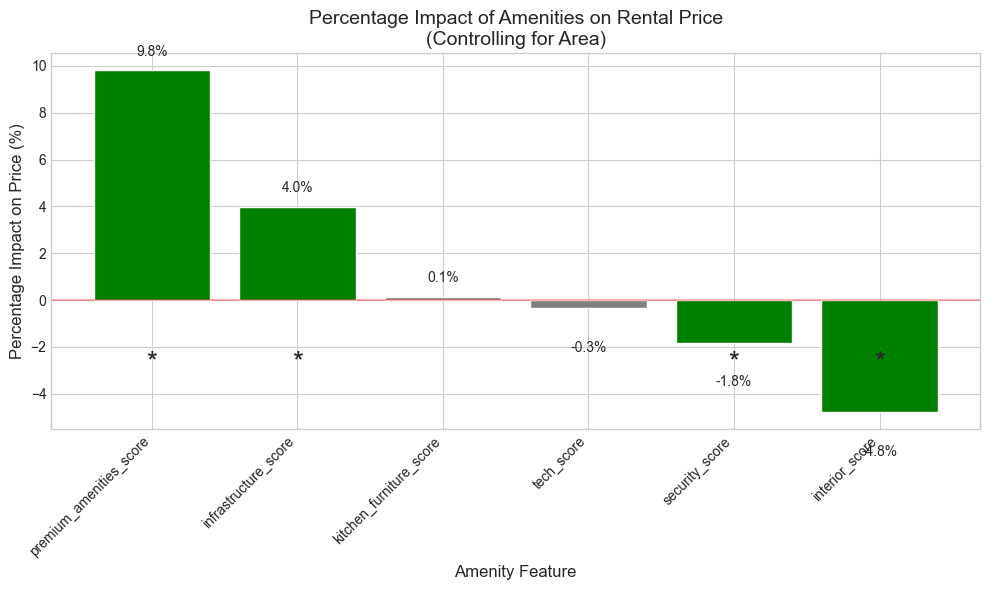

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Check dataframe for any unexpected issues
print("Checking for potential issues in the dataframe...")

# 1. Check for infinity values
has_inf = np.isinf(df.select_dtypes(include=['number'])).any().any()
print(f"DataFrame contains infinity values: {has_inf}")

# 2. Check for duplicate column names
dup_cols = df.columns[df.columns.duplicated()].tolist()
print(f"Duplicate column names: {dup_cols}")

# 3. Try creating the regression with numpy arrays directly to bypass pandas
# This is a more direct approach that can work even when pandas has issues
amenity_features = [
    'kitchen_furniture_score', 
    'security_score', 
    'tech_score', 
    'premium_amenities_score', 
    'infrastructure_score', 
    'interior_score'
]

print("\nRunning regression with numpy arrays directly:")

# Convert to numpy arrays directly from the dataframe
X_data = np.column_stack([
    df[amenity_features].values,  # Amenity features
    df['area'].values,            # Area
])

# Add a constant term (intercept)
X_data = sm.add_constant(X_data)

# Target variable
y_data = df['log_price'].values

try:
    # Run regression
    model = sm.OLS(y_data, X_data).fit()
    
    # Print results
    print("Regression successful using numpy arrays directly!")
    print(model.summary())
    
    # Calculate amenity impacts
    amenity_coefs = pd.DataFrame({
        'Amenity': amenity_features,
        'Coefficient': model.params[1:len(amenity_features)+1],  # Skip constant
        'P-Value': model.pvalues[1:len(amenity_features)+1],
        'Significant': model.pvalues[1:len(amenity_features)+1] < 0.05
    })
    
    # Calculate percentage impact
    amenity_coefs['Percentage_Impact'] = (np.exp(amenity_coefs['Coefficient']) - 1) * 100
    
    # Sort by impact
    amenity_coefs = amenity_coefs.sort_values('Percentage_Impact', ascending=False)
    
    print("\nPercentage impact of each amenity on rental price (controlling for area):")
    print(amenity_coefs)
    
except Exception as e:
    print(f"Error: {str(e)}")
    
# If all else fails, we can use sklearn's linear regression which is more robust to data issues
print("\nAlternative: Using scikit-learn for regression:")

# Prepare data
X_sk = df[amenity_features + ['area']].values
y_sk = df['log_price'].values

# Standardize features
scaler = StandardScaler()
X_sk_scaled = scaler.fit_transform(X_sk)

# Fit model
sk_model = LinearRegression()
sk_model.fit(X_sk_scaled, y_sk)

# Get coefficients
sk_coef = pd.DataFrame({
    'Amenity': amenity_features + ['area'],
    'Coefficient': sk_model.coef_[:len(amenity_features)+1],
})

print("Scikit-learn model coefficients:")
print(sk_coef)

# Create a visualization of amenity impacts from the successful model
try:
    plt.figure(figsize=(10, 6))
    
    # Use the amenity_coefs dataframe from successful model
    bars = plt.bar(amenity_coefs['Amenity'], amenity_coefs['Percentage_Impact'], 
                  color=['green' if sig else 'gray' for sig in amenity_coefs['Significant']])
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 
                height + (0.5 if height >= 0 else -2), 
                f'{amenity_coefs["Percentage_Impact"].iloc[i]:.1f}%', 
                ha='center', va='bottom')
    
    # Add significance markers
    for i, sig in enumerate(amenity_coefs['Significant']):
        if sig:
            plt.text(bars[i].get_x() + bars[i].get_width()/2., -3, '*', ha='center', fontsize=20)
    
    plt.title('Percentage Impact of Amenities on Rental Price\n(Controlling for Area)', fontsize=14)
    plt.xlabel('Amenity Feature', fontsize=12)
    plt.ylabel('Percentage Impact on Price (%)', fontsize=12)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating visualization: {str(e)}")

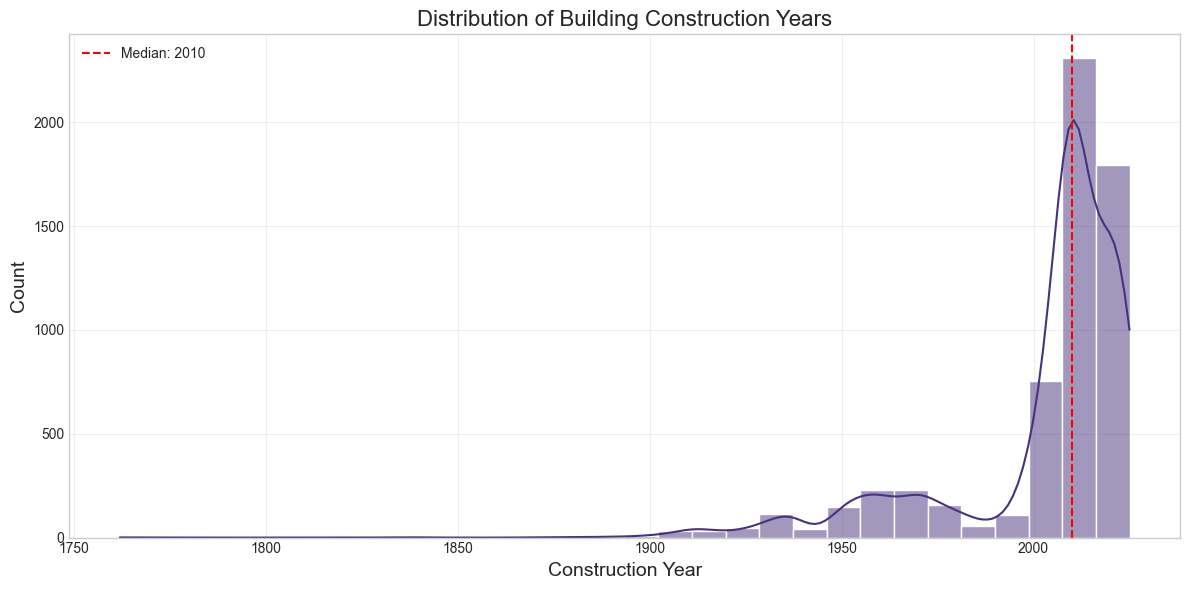

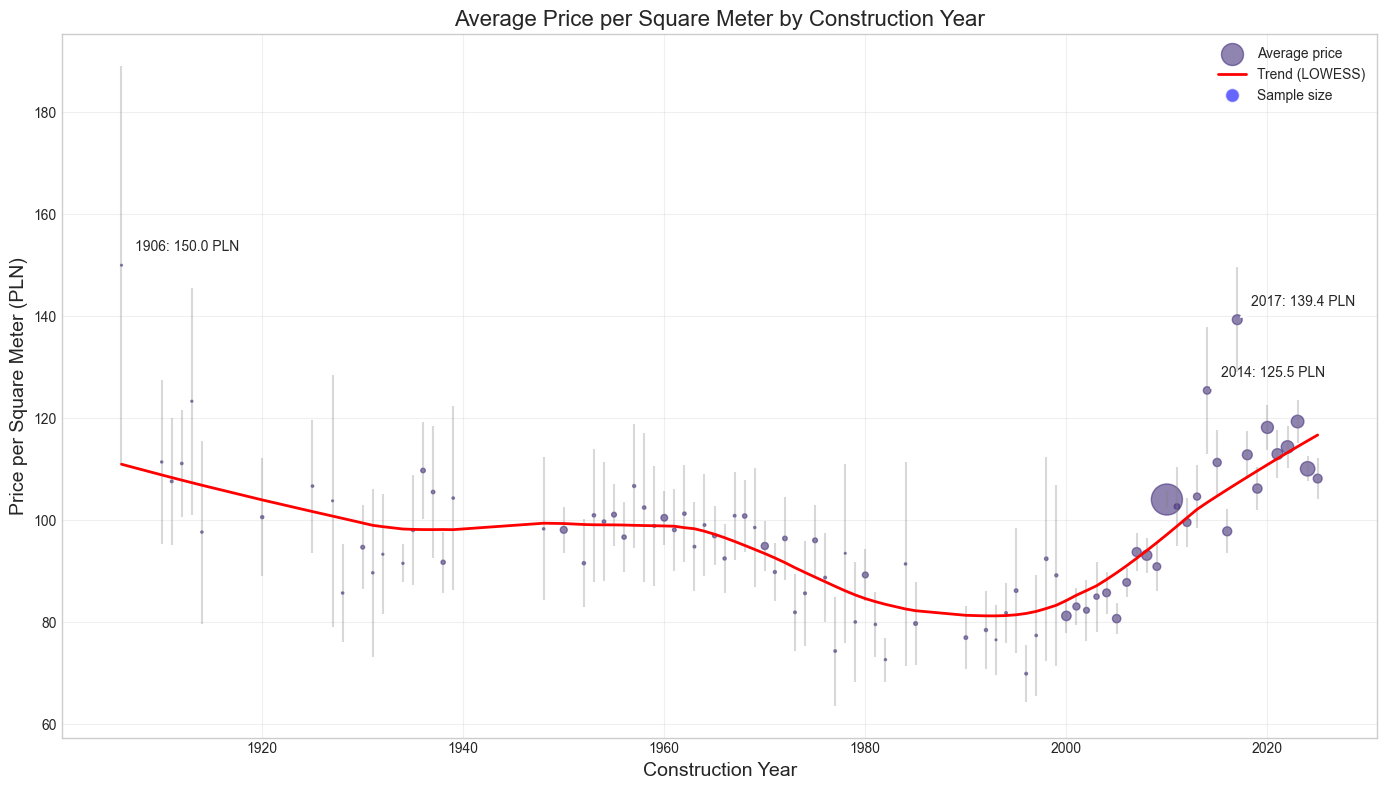

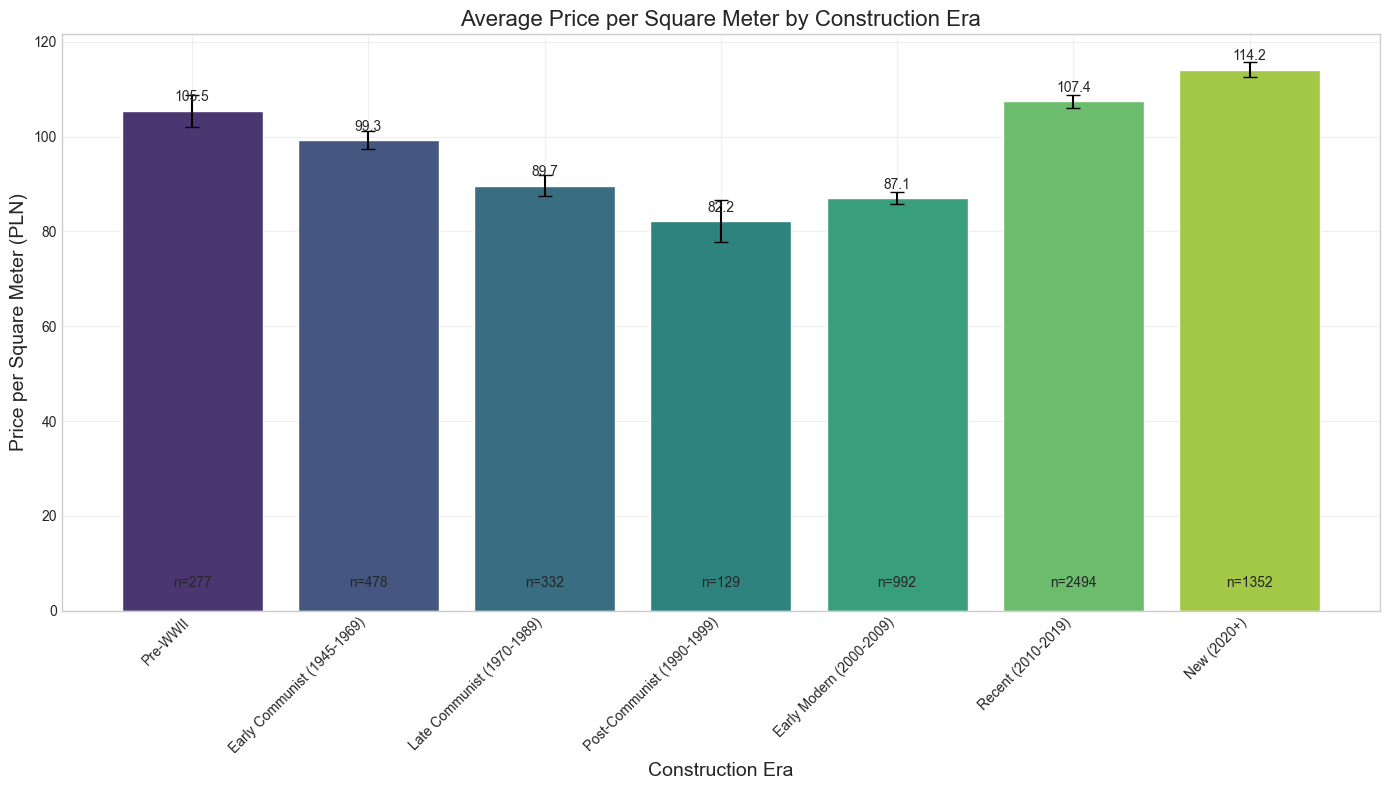

Regression Analysis: Price per Square Meter vs. Building Age
                            OLS Regression Results                            
Dep. Variable:          price_per_sqm   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     74.88
Date:                Mon, 19 May 2025   Prob (F-statistic):           6.34e-18
Time:                        14:47:33   Log-Likelihood:                -29557.
No. Observations:                6054   AIC:                         5.912e+04
Df Residuals:                    6052   BIC:                         5.913e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

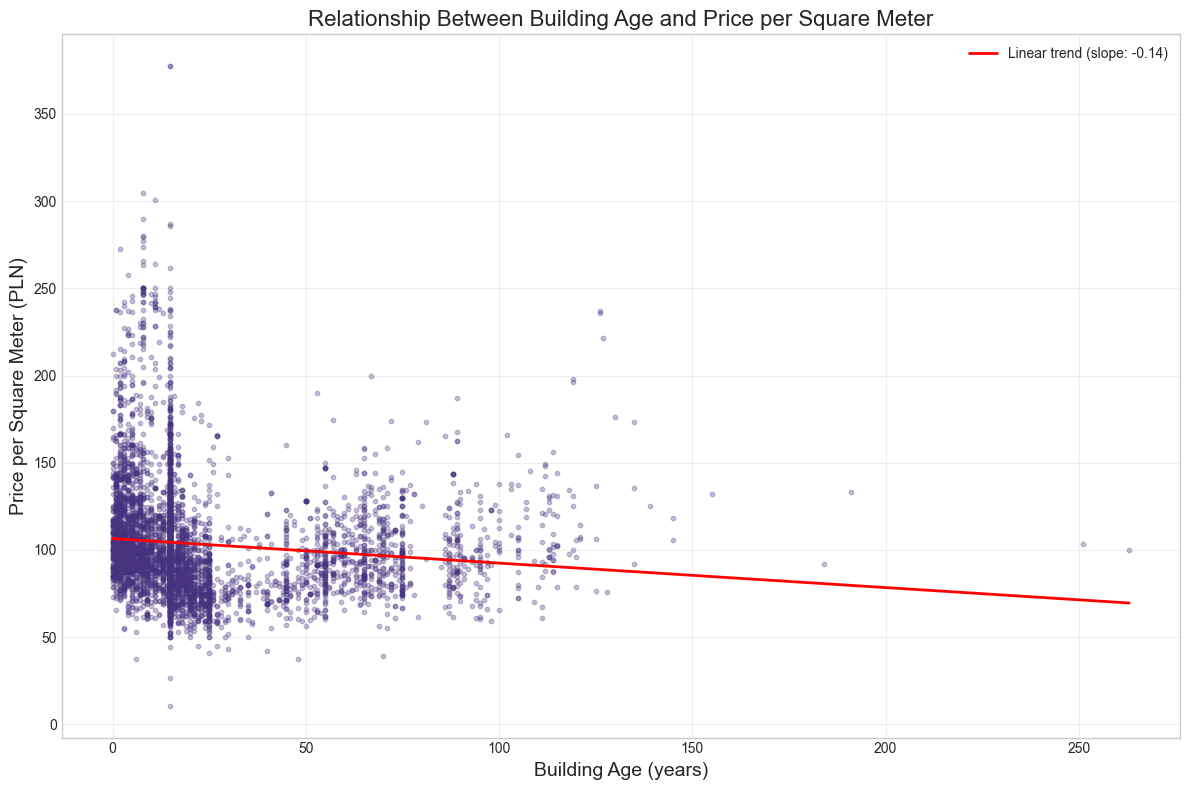

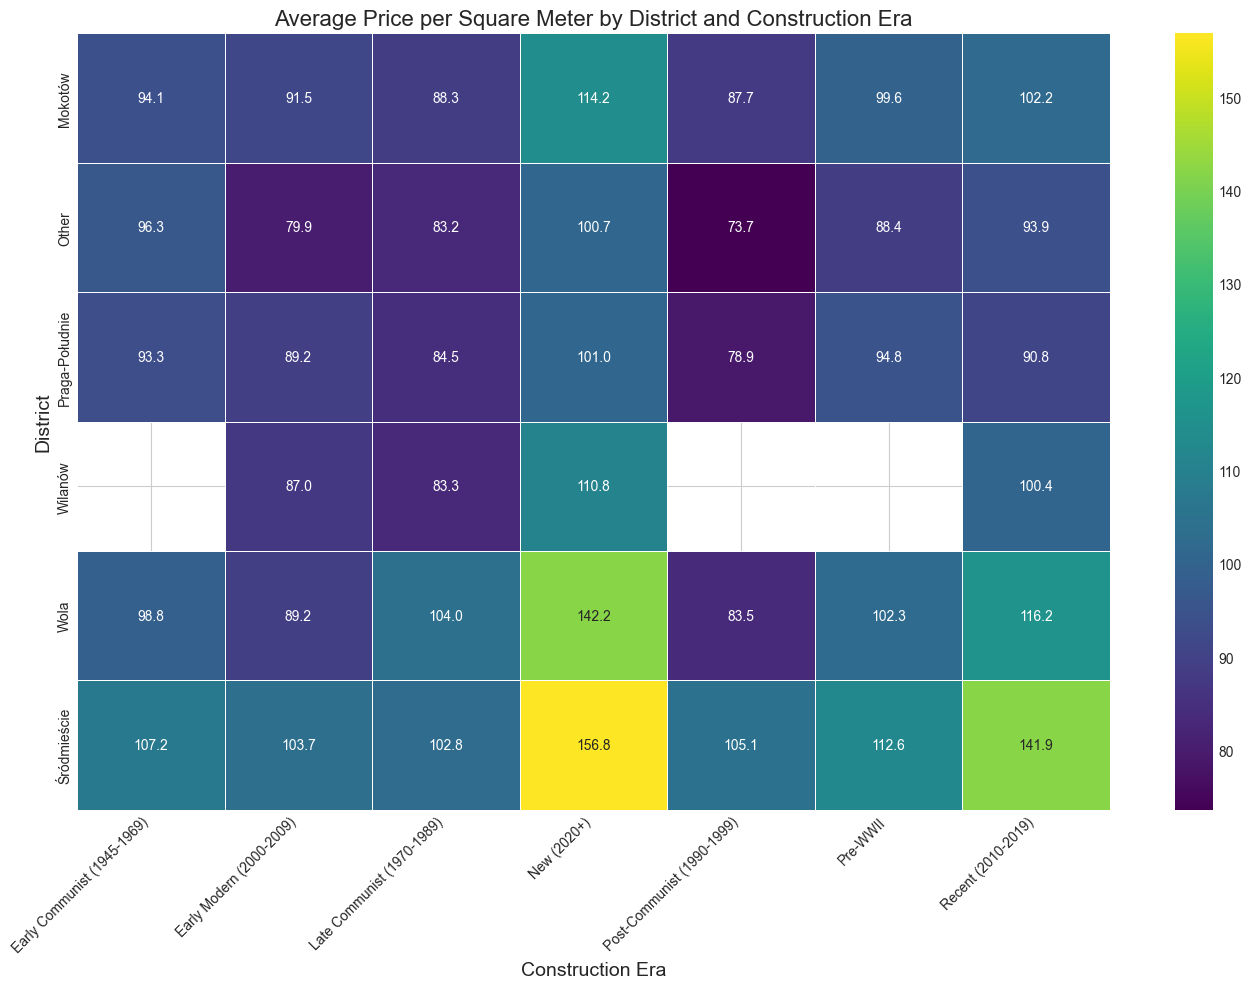

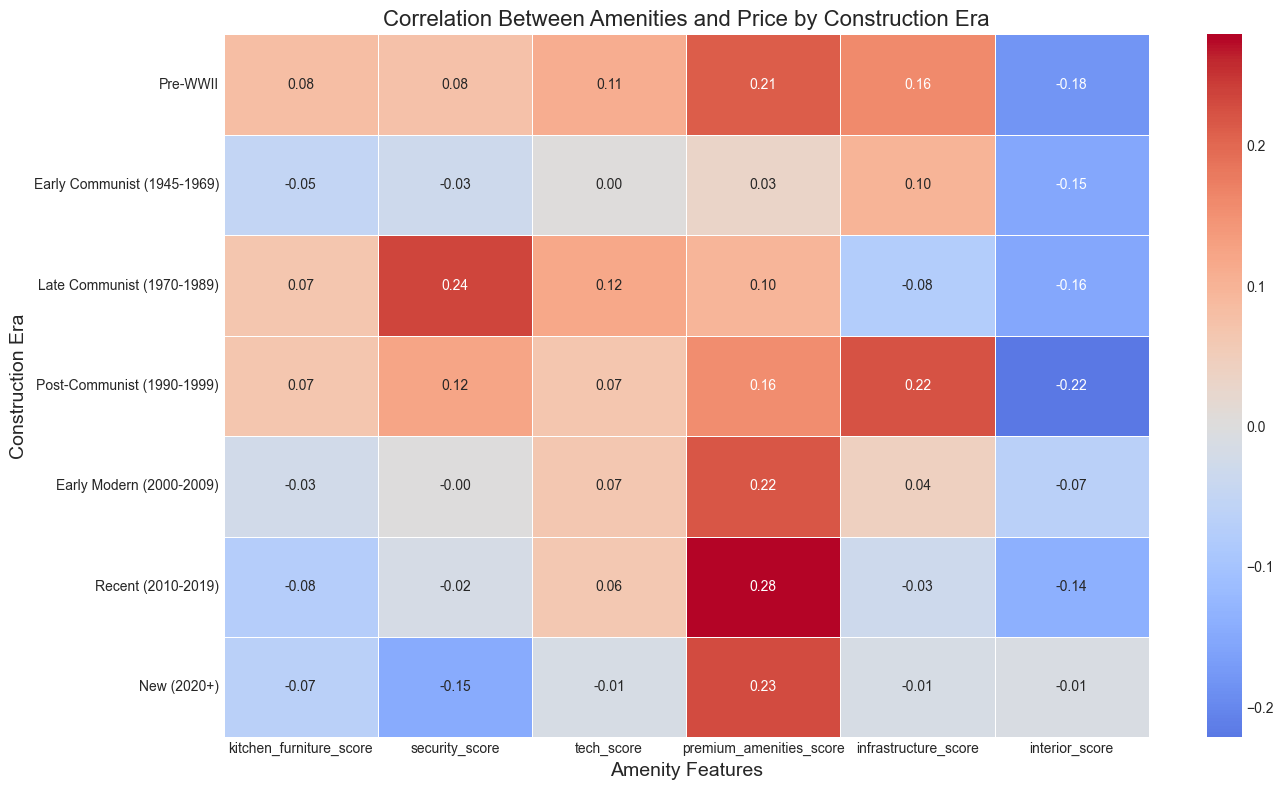


Summary Statistics by Construction Era:
                           Era  Average Price (PLN/sqm)  \
5                     Pre-WWII                   105.50   
0  Early Communist (1945-1969)                    99.27   
2   Late Communist (1970-1989)                    89.68   
4   Post-Communist (1990-1999)                    82.20   
1     Early Modern (2000-2009)                    87.06   
6           Recent (2010-2019)                   107.44   
3                  New (2020+)                   114.17   

   Median Price (PLN/sqm)  Sample Size  Premium/Discount vs. Average (%)  
5                  100.00          277                              2.07  
0                   96.65          478                             -3.95  
2                   86.63          332                            -13.23  
4                   75.80          129                            -20.47  
1                   83.50          992                            -15.77  
6                   98.63         24

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# 1. Overall distribution of building years
plt.figure(figsize=(12, 6))
sns.histplot(df['build_year'].dropna(), bins=30, kde=True)
plt.title('Distribution of Building Construction Years', fontsize=16)
plt.xlabel('Construction Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.axvline(df['build_year'].median(), color='red', linestyle='--', label=f'Median: {df["build_year"].median():.0f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Average price per square meter by construction year
# Group data by construction year and calculate statistics
year_groups = df.groupby('build_year')['price_per_sqm'].agg(['mean', 'median', 'count', 'std']).reset_index()
year_groups = year_groups.rename(columns={'mean': 'avg_price_per_sqm', 'median': 'median_price_per_sqm'})

# Calculate confidence intervals
year_groups['ci_95'] = 1.96 * year_groups['std'] / np.sqrt(year_groups['count'])

# Filter out years with too few samples (less than 5)
filtered_years = year_groups[year_groups['count'] >= 5].sort_values('build_year')

# Plot average price per square meter by construction year
plt.figure(figsize=(14, 8))

# Scatter plot with size based on count
scatter = plt.scatter(filtered_years['build_year'], filtered_years['avg_price_per_sqm'], 
                      s=filtered_years['count']/3, alpha=0.6, label='Average price')

# Add error bars
plt.errorbar(filtered_years['build_year'], filtered_years['avg_price_per_sqm'],
             yerr=filtered_years['ci_95'], fmt='none', alpha=0.3, color='gray')

# Add trend line using LOWESS smoothing
smoothed = lowess(filtered_years['avg_price_per_sqm'], filtered_years['build_year'], frac=0.3)
plt.plot(smoothed[:, 0], smoothed[:, 1], 'r-', linewidth=2, label='Trend (LOWESS)')

plt.title('Average Price per Square Meter by Construction Year', fontsize=16)
plt.xlabel('Construction Year', fontsize=14)
plt.ylabel('Price per Square Meter (PLN)', fontsize=14)
plt.grid(True, alpha=0.3)

# Add a legend for bubble size
handles, labels = plt.gca().get_legend_handles_labels()
from matplotlib.lines import Line2D
handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                     markersize=10, alpha=0.6, label='Sample size'))
plt.legend(handles=handles)

# Add text annotations for notable points
top_years = filtered_years.sort_values('avg_price_per_sqm', ascending=False).head(3)
for idx, row in top_years.iterrows():
    plt.annotate(f"{int(row['build_year'])}: {row['avg_price_per_sqm']:.1f} PLN",
                xy=(row['build_year'], row['avg_price_per_sqm']),
                xytext=(10, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

# 3. Create construction era categories and analyze price differences
# Define eras based on architectural/historical periods in Poland
def categorize_era(year):
    if pd.isna(year):
        return "Unknown"
    elif year < 1945:
        return "Pre-WWII"
    elif year < 1970:
        return "Early Communist (1945-1969)"
    elif year < 1989:
        return "Late Communist (1970-1989)"
    elif year < 2000:
        return "Post-Communist (1990-1999)"
    elif year < 2010:
        return "Early Modern (2000-2009)"
    elif year < 2020:
        return "Recent (2010-2019)"
    else:
        return "New (2020+)"

# Add era category
df['construction_era'] = df['build_year'].apply(categorize_era)

# Analyze prices by era
era_prices = df.groupby('construction_era')['price_per_sqm'].agg(['mean', 'median', 'count', 'std']).reset_index()
era_prices = era_prices.rename(columns={'mean': 'avg_price_per_sqm', 'median': 'median_price_per_sqm'})

# Calculate confidence intervals
era_prices['ci_95'] = 1.96 * era_prices['std'] / np.sqrt(era_prices['count'])

# Sort by chronological order of eras
era_order = ["Pre-WWII", "Early Communist (1945-1969)", "Late Communist (1970-1989)", 
            "Post-Communist (1990-1999)", "Early Modern (2000-2009)", "Recent (2010-2019)", 
            "New (2020+)", "Unknown"]
era_prices['era_order'] = era_prices['construction_era'].map({era: i for i, era in enumerate(era_order)})
era_prices = era_prices.sort_values('era_order')

# Plot average price by construction era
plt.figure(figsize=(14, 8))

# Create bar chart
bars = sns.barplot(x='construction_era', y='avg_price_per_sqm', data=era_prices, 
                  order=[e for e in era_order if e in era_prices['construction_era'].values],
                  palette='viridis')

# Add error bars
plt.errorbar(x=np.arange(len(era_prices)), y=era_prices['avg_price_per_sqm'],
            yerr=era_prices['ci_95'], fmt='none', color='black', capsize=5)

# Add count labels
for i, row in enumerate(era_prices.itertuples()):
    plt.text(i, 5, f'n={row.count}', ha='center', fontsize=10)

# Add price labels
for i, bar in enumerate(bars.patches):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{era_prices["avg_price_per_sqm"].iloc[i]:.1f}',
            ha='center', fontsize=10)

plt.title('Average Price per Square Meter by Construction Era', fontsize=16)
plt.xlabel('Construction Era', fontsize=14)
plt.ylabel('Price per Square Meter (PLN)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Regression analysis: Price vs. Building Age
# Create a numeric age column
current_year = 2025  # Current year (adjust as needed)
df['building_age'] = current_year - df['build_year']

# Run regression to quantify the relationship
X = sm.add_constant(df['building_age'].dropna())
y = df.loc[X.index, 'price_per_sqm']

try:
    model = sm.OLS(y, X).fit()
    print("Regression Analysis: Price per Square Meter vs. Building Age")
    print(model.summary())
    
    # Calculate price impact per year of age
    age_coef = model.params['building_age']
    age_impact_pct = (age_coef / df['price_per_sqm'].mean()) * 100
    print(f"\nImpact of Building Age on Price:")
    print(f"For each additional year of age, price changes by {age_coef:.2f} PLN/sqm")
    print(f"This represents approximately {age_impact_pct:.2f}% of the average price")
    
    # Create a scatter plot with regression line
    plt.figure(figsize=(12, 8))
    
    # Plot actual data points with alpha for density
    plt.scatter(df['building_age'], df['price_per_sqm'], alpha=0.3, s=10)
    
    # Plot regression line
    x_range = np.linspace(df['building_age'].min(), df['building_age'].max(), 100)
    plt.plot(x_range, model.params['const'] + model.params['building_age'] * x_range, 
             'r-', linewidth=2, label=f'Linear trend (slope: {age_coef:.2f})')
    
    plt.title('Relationship Between Building Age and Price per Square Meter', fontsize=16)
    plt.xlabel('Building Age (years)', fontsize=14)
    plt.ylabel('Price per Square Meter (PLN)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in regression analysis: {str(e)}")

# 5. Interaction between construction year and district
# Calculate average price per district and construction era
district_era_prices = df.groupby(['district_standardized', 'construction_era'])['price_per_sqm'].mean().reset_index()

# Get top 6 districts by count
top_districts = df['district_standardized'].value_counts().head(6).index.tolist()
district_era_filtered = district_era_prices[district_era_prices['district_standardized'].isin(top_districts)]

# Create a heatmap
plt.figure(figsize=(14, 10))
heatmap_data = district_era_filtered.pivot(index='district_standardized', 
                                          columns='construction_era', 
                                          values='price_per_sqm')

sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='viridis', linewidths=.5)
plt.title('Average Price per Square Meter by District and Construction Era', fontsize=16)
plt.xlabel('Construction Era', fontsize=14)
plt.ylabel('District', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 6. Price vs. quality by building age
# Calculate correlation between amenity scores and price for different construction eras
correlation_by_era = pd.DataFrame(index=df['construction_era'].unique())

for era in df['construction_era'].unique():
    era_df = df[df['construction_era'] == era]
    
    # Calculate correlations with price for this era
    corrs = era_df[amenity_features + ['price_per_sqm']].corr()['price_per_sqm'].drop('price_per_sqm')
    
    # Add to results
    for feature in amenity_features:
        correlation_by_era.loc[era, feature] = corrs[feature]

# Sort by chronological order
correlation_by_era = correlation_by_era.reindex([e for e in era_order if e in correlation_by_era.index])

# Plot correlation heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_by_era, annot=True, fmt='.2f', cmap='coolwarm', center=0, linewidths=.5)
plt.title('Correlation Between Amenities and Price by Construction Era', fontsize=16)
plt.xlabel('Amenity Features', fontsize=14)
plt.ylabel('Construction Era', fontsize=14)
plt.tight_layout()
plt.show()

# 7. Summary statistics table
summary_stats = pd.DataFrame({
    'Era': era_prices['construction_era'],
    'Average Price (PLN/sqm)': era_prices['avg_price_per_sqm'].round(2),
    'Median Price (PLN/sqm)': era_prices['median_price_per_sqm'].round(2),
    'Sample Size': era_prices['count'],
    'Premium/Discount vs. Average (%)': ((era_prices['avg_price_per_sqm'] / df['price_per_sqm'].mean() - 1) * 100).round(2)
})

print("\nSummary Statistics by Construction Era:")
print(summary_stats)

In [56]:
from sklearn.preprocessing import StandardScaler

# Features to standardize (z-score normalization)
features_to_standardize = [
    'area', 'distance_to_center', 
    'building_floors_num', 'floor_numeric', 'build_year', 
    'relative_floor_position'
]

# Initialize the StandardScaler (for z-score normalization)
scaler = StandardScaler()

# Keep track of original statistics for reporting
original_means = df[features_to_standardize].mean()
original_stds = df[features_to_standardize].std()

# Create new columns for standardized features
standardized_column_names = [f"{feature}_std" for feature in features_to_standardize]

# Fit and transform all features at once
standardized_values = scaler.fit_transform(df[features_to_standardize])

# Add standardized columns to dataframe
for i, feature in enumerate(standardized_column_names):
    df[feature] = standardized_values[:, i]

# Print before/after summary
print("Z-score normalization applied to new columns with '_std' suffix:")
for i, feature in enumerate(features_to_standardize):
    std_feature = standardized_column_names[i]
    print(f"Original {feature}: mean={original_means[feature]:.2f}, std={original_stds[feature]:.2f}")
    print(f"Standardized {std_feature}: mean={df[std_feature].mean():.2f}, std={df[std_feature].std():.2f}")

# Preview the normalized data
print("\nPreview of standardized features:")
print(df[standardized_column_names].head())

# Store standardized column names for later use
print(f"\nStandardized column names: {standardized_column_names}")

Z-score normalization applied to new columns with '_std' suffix:
Original area: mean=60.25, std=33.58
Standardized area_std: mean=-0.00, std=1.00
Original distance_to_center: mean=6.56, std=3.94
Standardized distance_to_center_std: mean=0.00, std=1.00
Original building_floors_num: mean=7.10, std=6.15
Standardized building_floors_num_std: mean=0.00, std=1.00
Original floor_numeric: mean=3.51, std=2.76
Standardized floor_numeric_std: mean=-0.00, std=1.00
Original build_year: mean=2002.61, std=25.28
Standardized build_year_std: mean=0.00, std=1.00
Original relative_floor_position: mean=0.54, std=0.35
Standardized relative_floor_position_std: mean=-0.00, std=1.00

Preview of standardized features:
   area_std  distance_to_center_std  building_floors_num_std  \
0  0.290241               -0.812307                -0.503729   
1  0.081795                0.279218                 0.146778   
2 -0.811544                0.025501                 1.447792   
3 -0.126651                3.993850      

In [57]:
# price	price_per_sqm	construction_era	building_age
columns_to_drop = [
    'url', 'street', 'latitude', 'longitude',
    'price', 'price_per_sqm',
    'construction_era',
    'building_age'

]

# Drop the columns
df = df.drop(columns=columns_to_drop)

# Verify the columns were dropped
print(f"DataFrame shape: {df.shape}")
print(f"Number of columns dropped: {len(columns_to_drop)}")

DataFrame shape: (6054, 59)
Number of columns dropped: 8


In [58]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_info_columns', 10000)  # Ensures no cutoff in df.info()
from io import StringIO


buffer = StringIO()
df.info(verbose=True, show_counts=True, buf=buffer)
info_str = buffer.getvalue()
print(info_str)  # Now you'll see all columns including column 20
with open("df_info.txt", "w") as f:
    df.info(verbose=True, show_counts=True, buf=f)
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 59 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   area                              6054 non-null   float64
 1   rooms_num                         6054 non-null   int64  
 2   building_floors_num               6054 non-null   float64
 3   deposit                           6054 non-null   float64
 4   build_year                        6054 non-null   float64
 5   total_price                       6054 non-null   float64
 6   district_standardized             6054 non-null   object 
 7   district_Bemowo                   6054 non-null   int64  
 8   district_Białołęka                6054 non-null   int64  
 9   district_Bielany                  6054 non-null   int64  
 10  district_Mokotów                  6054 non-null   int64  
 11  district_Ochota                   6054 non-null   int64  
 12  distri

,area,rooms_num,building_floors_num,deposit,build_year,total_price,district_standardized,district_Bemowo,district_Białołęka,district_Bielany,district_Mokotów,district_Ochota,district_Other,district_Praga-Południe,district_Praga-Północ,district_Targówek,district_Ursus,district_Ursynów,district_Wilanów,district_Wola,district_Włochy,district_Śródmieście,district_Żoliborz,district_other,building_type_standardized,building_type_apartment,building_type_tenement,windows_type_standardized,window_plastic,window_wooden,user_type_standardized,user_type_agency,heating_standardized,heating_urban,construction_status_standardized,construction_ready_to_use,building_material_standardized,material_brick,material_concrete,material_concrete_plate,floor_standardized,floor_numeric,distance_to_center,relative_floor_position,is_top_floor,property_age_group,log_price,kitchen_furniture_score,security_score,tech_score,premium_amenities_score,infrastructure_score,interior_score,area_std,distance_to_center_std,building_floors_num_std,floor_numeric_std,build_year_std,relative_floor_position_std
0,70.0,3,4.0,17000.0,2018.0,9750.0,Ochota,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,apartment,1,0,wooden,0,1,private_owner,0,urban,1,ready_to_use,1,brick,1,0,0,3,3.0,3.360371,0.750000,0,Recent,9.185023,7,5,2,2,3,1,0.290241,-0.812307,-0.503729,-0.186078,0.608635,0.601185
1,63.0,3,8.0,6000.0,2015.0,5700.0,Ursynów,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,apartment,1,0,plastic,1,0,private_owner,0,urban,1,ready_to_use,1,brick,1,0,0,5,5.0,7.665445,0.625000,0,Recent,8.648221,7,3,2,1,3,2,0.081795,0.279218,0.146778,0.537905,0.489954,0.248404
2,33.0,2,16.0,3400.0,2021.0,3900.0,Wola,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,block,0,0,plastic,1,0,private_owner,0,urban,1,ready_to_use,1,concrete_plate,0,0,1,9,9.0,6.664762,0.562500,0,New,8.268732,6,2,0,0,3,0,-0.811544,0.025501,1.447792,1.985873,0.727315,0.072014
3,56.0,3,3.0,5000.0,2023.0,4300.0,Other,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,block,0,0,plastic,1,0,private_owner,0,Other,0,Other,0,Other,0,0,0,2,2.0,22.316281,0.666667,0,New,8.366370,5,3,2,0,3,1,-0.126651,3.993850,-0.666356,-0.548070,0.806435,0.365998
4,65.0,3,17.0,18000.0,2010.0,9500.0,Wola,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,apartment,1,0,Other,0,0,agency,1,urban,1,Other,0,Other,0,0,0,1,1.0,5.923853,0.058824,0,Recent,9.159047,1,3,2,1,3,0,0.141351,-0.162352,1.610419,-0.910062,0.292153,-1.349484
5,65.0,3,24.0,7500.0,2010.0,7500.0,Wola,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Other,0,0,Other,0,0,agency,1,Other,0,Other,0,Other,0,0,0,2,2.0,5.923853,0.083333,0,Recent,8.922658,1,0,0,0,3,1,0.141351,-0.162352,2.748807,-0.548070,0.292153,-1.280312
6,44.0,2,8.0,4500.0,2024.0,3880.0,Praga-Południe,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,block,0,0,plastic,1,0,private_owner,0,urban,1,ready_to_use,1,Other,0,0,0,5,5.0,9.486081,0.625000,0,New,8.263590,6,3,3,0,2,0,-0.483986,0.740830,0.146778,0.537905,0.845996,0.248404
7,49.7,2,2.0,4500.0,2010.0,4164.0,Włochy,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,block,0,0,Other,0,0,agency,1,Other,0,ready_to_use,1,Other,0,0,0,2,2.0,9.399184,1.000000,1,Recent,8.334231,6,2,1,0,2,0,-0.314252,0.718798,-0.828983,-0.548070,0.292153,1.306746
8,60.0,3,6.0,3000.0,2010.0,4200.0,Targówek,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,block,0,0,plastic,1,0,private_owner,0,urban,1,Other,0,Other,0,0,0,4,4.0,6.474068,0.666667,0,Recent,8.342840,6,2,0,0,1,1,-0.007539,-0.022848,-0.178476,0.175913,0.292153,0.365998
9,200.0,4,10.0,14000.0,2004.0,15200.0,Wola,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Other,0,0,plastic,1,0,agency,1,Other,0,ready_to_use,1,Other,0,0,0,6,6.0,1.609931,0.600000,0,Modern,9.629051,6,0,0,0,2,0,4.161379,-1.256121,0.472031,0.899897,0.054792,0.177848


In [59]:
df.to_csv('clean3.csv', index=False)